In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

def gather_data(data_codes, 
                start,
                end = datetime.datetime.today(),
                freq = "M"):
    df_created = False
    for name, code in data_codes.items():
        if df_created ==False:
            df = web.DataReader(
                 code, "fred", start, end).resample(freq).mean()
            df.rename(columns = {code:name}, inplace = True)
            df_created = True
        else:
            df[name] = web.DataReader(
            code, "fred", start, end).resample(freq).mean()
    return df

def bill_to_mill(series):
    return series * 10 ** 3

start = datetime.datetime(2002, 1, 1)
end = datetime.datetime.today()
freq = "M"

In [2]:
from datlib.plots import *
#from datlib.FRED import *

data_codes = {"Monetary Base": "BOGMBASE",
              "Base: Currency in Circulation": "WCURCIR"}

base = gather_data(data_codes,
                   start,
                   end,
                   freq)

In [3]:
base

Monetary Base  Base: Currency in Circulation
DATE                                                    
2002-01-31       653800.0                      635.42900
2002-02-28       654600.0                      635.88400
2002-03-31       659000.0                      639.69750
2002-04-30       663400.0                      643.57950
2002-05-31       668600.0                      648.29320
...                   ...                            ...
2021-04-30      6042100.0                     2154.81925
2021-05-31      6041900.0                     2167.93400
2021-06-30      6027100.0                     2178.87120
2021-07-31      6130300.0                     2186.18425
2021-08-31      6328800.0                     2187.68875

[236 rows x 2 columns]

In [21]:
data_codes  = {"Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Mil)": "WCURCIR",
               # Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Excess Reserves ($ Mil)": "EXCSRESNW",
               "Balance Sheet: Required Reserves ($ Mil)": "RESBALREQW",
               "Balance Sheet: Total Reserves ($ Mil)": "WRESBAL",
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Interest Rates
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER",
               # Req Reserves and Vault Cash
               "Vault Cash ($ Mil)": "TLVAULTW",
               "Vault Cash Used as Req. ($ Mil)": "VAULT",
               }

data = gather_data(data_codes = data_codes,
                  start = start,
                  end = end,
                  freq = "M")

In [22]:
bill_to_mill_list = ["Balance Sheet: Total Reserves ($ Mil)",
                  "Balance Sheet: Other Deposits ($ Mil)",
                  "Base: Currency in Circulation ($ Mil)"]
for key in bill_to_mill_list:
    data[key] = bill_to_mill(data[key])

<AxesSubplot:xlabel='DATE'>

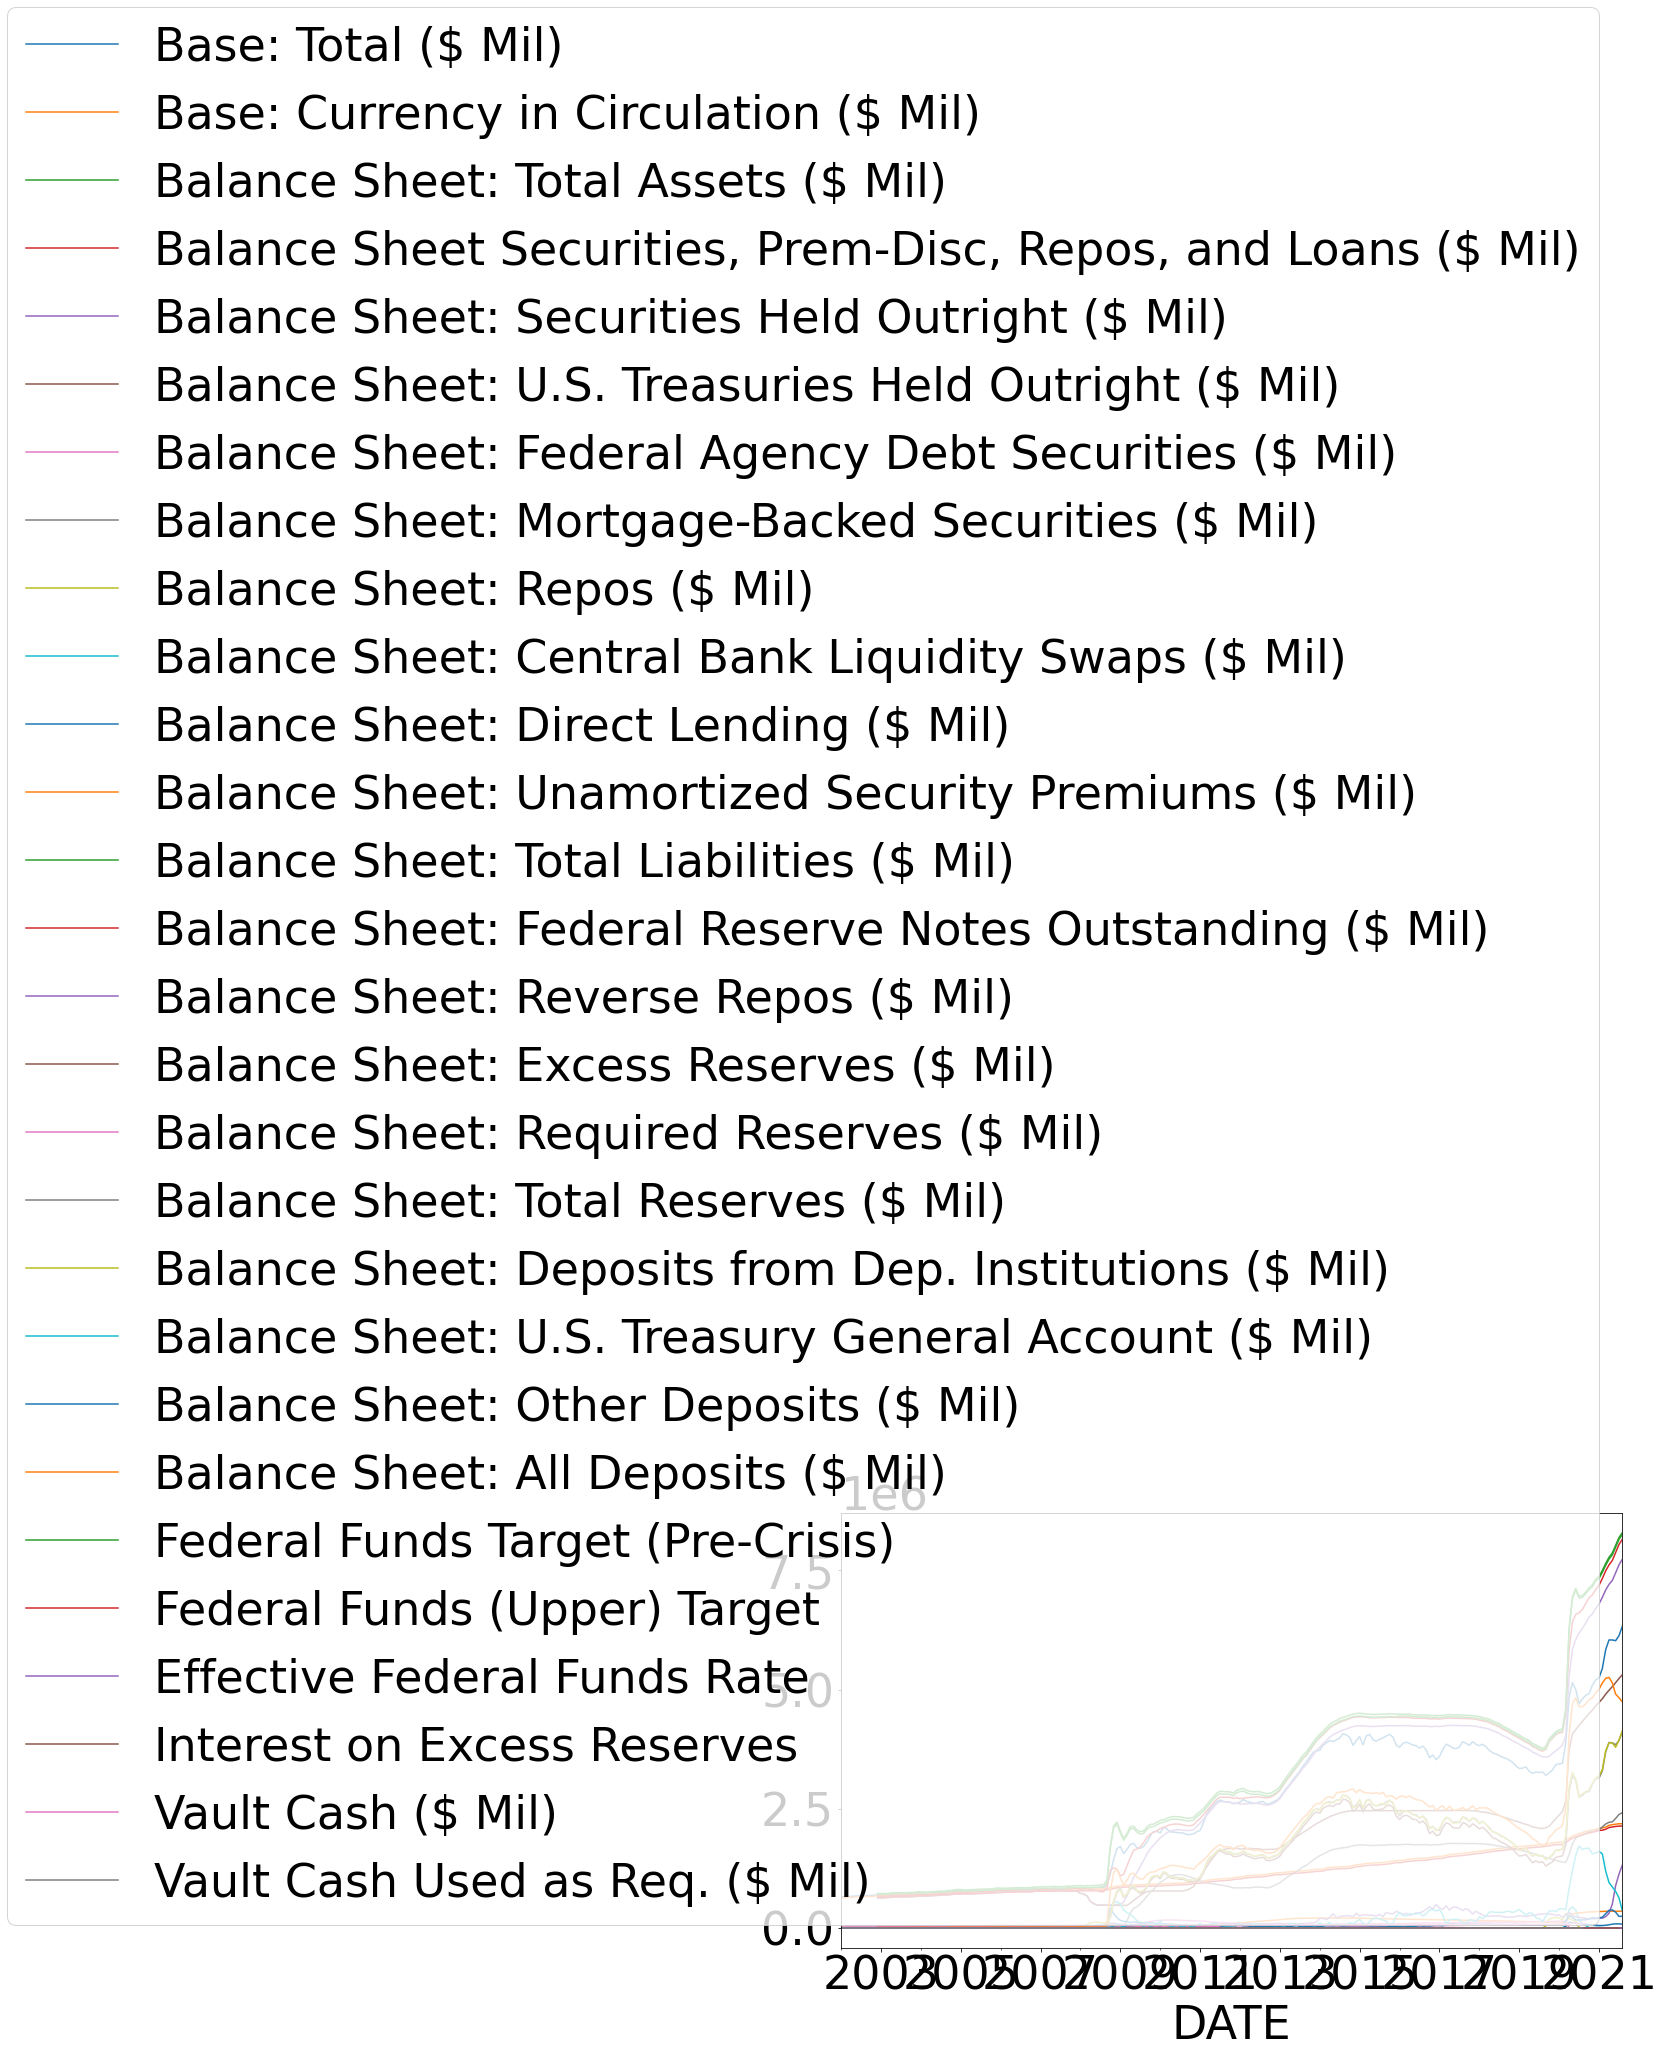

In [23]:
fig, ax = plt.subplots(figsize = (14,8))
data.plot(ax = ax)

In [24]:
from matplotlib.backends.backend_pdf import PdfPages
def plot_lines(df,
               title="",
              linewidth = 1,
              figsize  = (40,20),
              secondary_y = None,
              legend = True, 
               pp = None,
              save_fig = False):
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_title(title)
    # drop empty rows
    df.dropna(axis=0, how = "all").plot.line(
        linewidth = linewidth,
        secondary_y = secondary_y,
        legend = legend,
        ax = ax)
    ax.tick_params(axis="x", rotation = 90)
    # remove ticklines
    ax.tick_params("both", length = 0, which="both")
    vals = ax.get_yticks()
    ax.set_yticklabels([round(x, 2) for x in vals])
    
    #format image filename
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")
    # create a folder for .png files
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        # save figure as png file
        # bbox_inches = "tight" is for formatting
        plt.savefig("plots/" + filename[:50] + "Lines.png",
                   bbox_inches = "tight")
    if pp != None: 
        pp.savefig(fig, bbox_inches = "tight")

<ipython-input-24-d2f49b60d242>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x, 2) for x in vals])


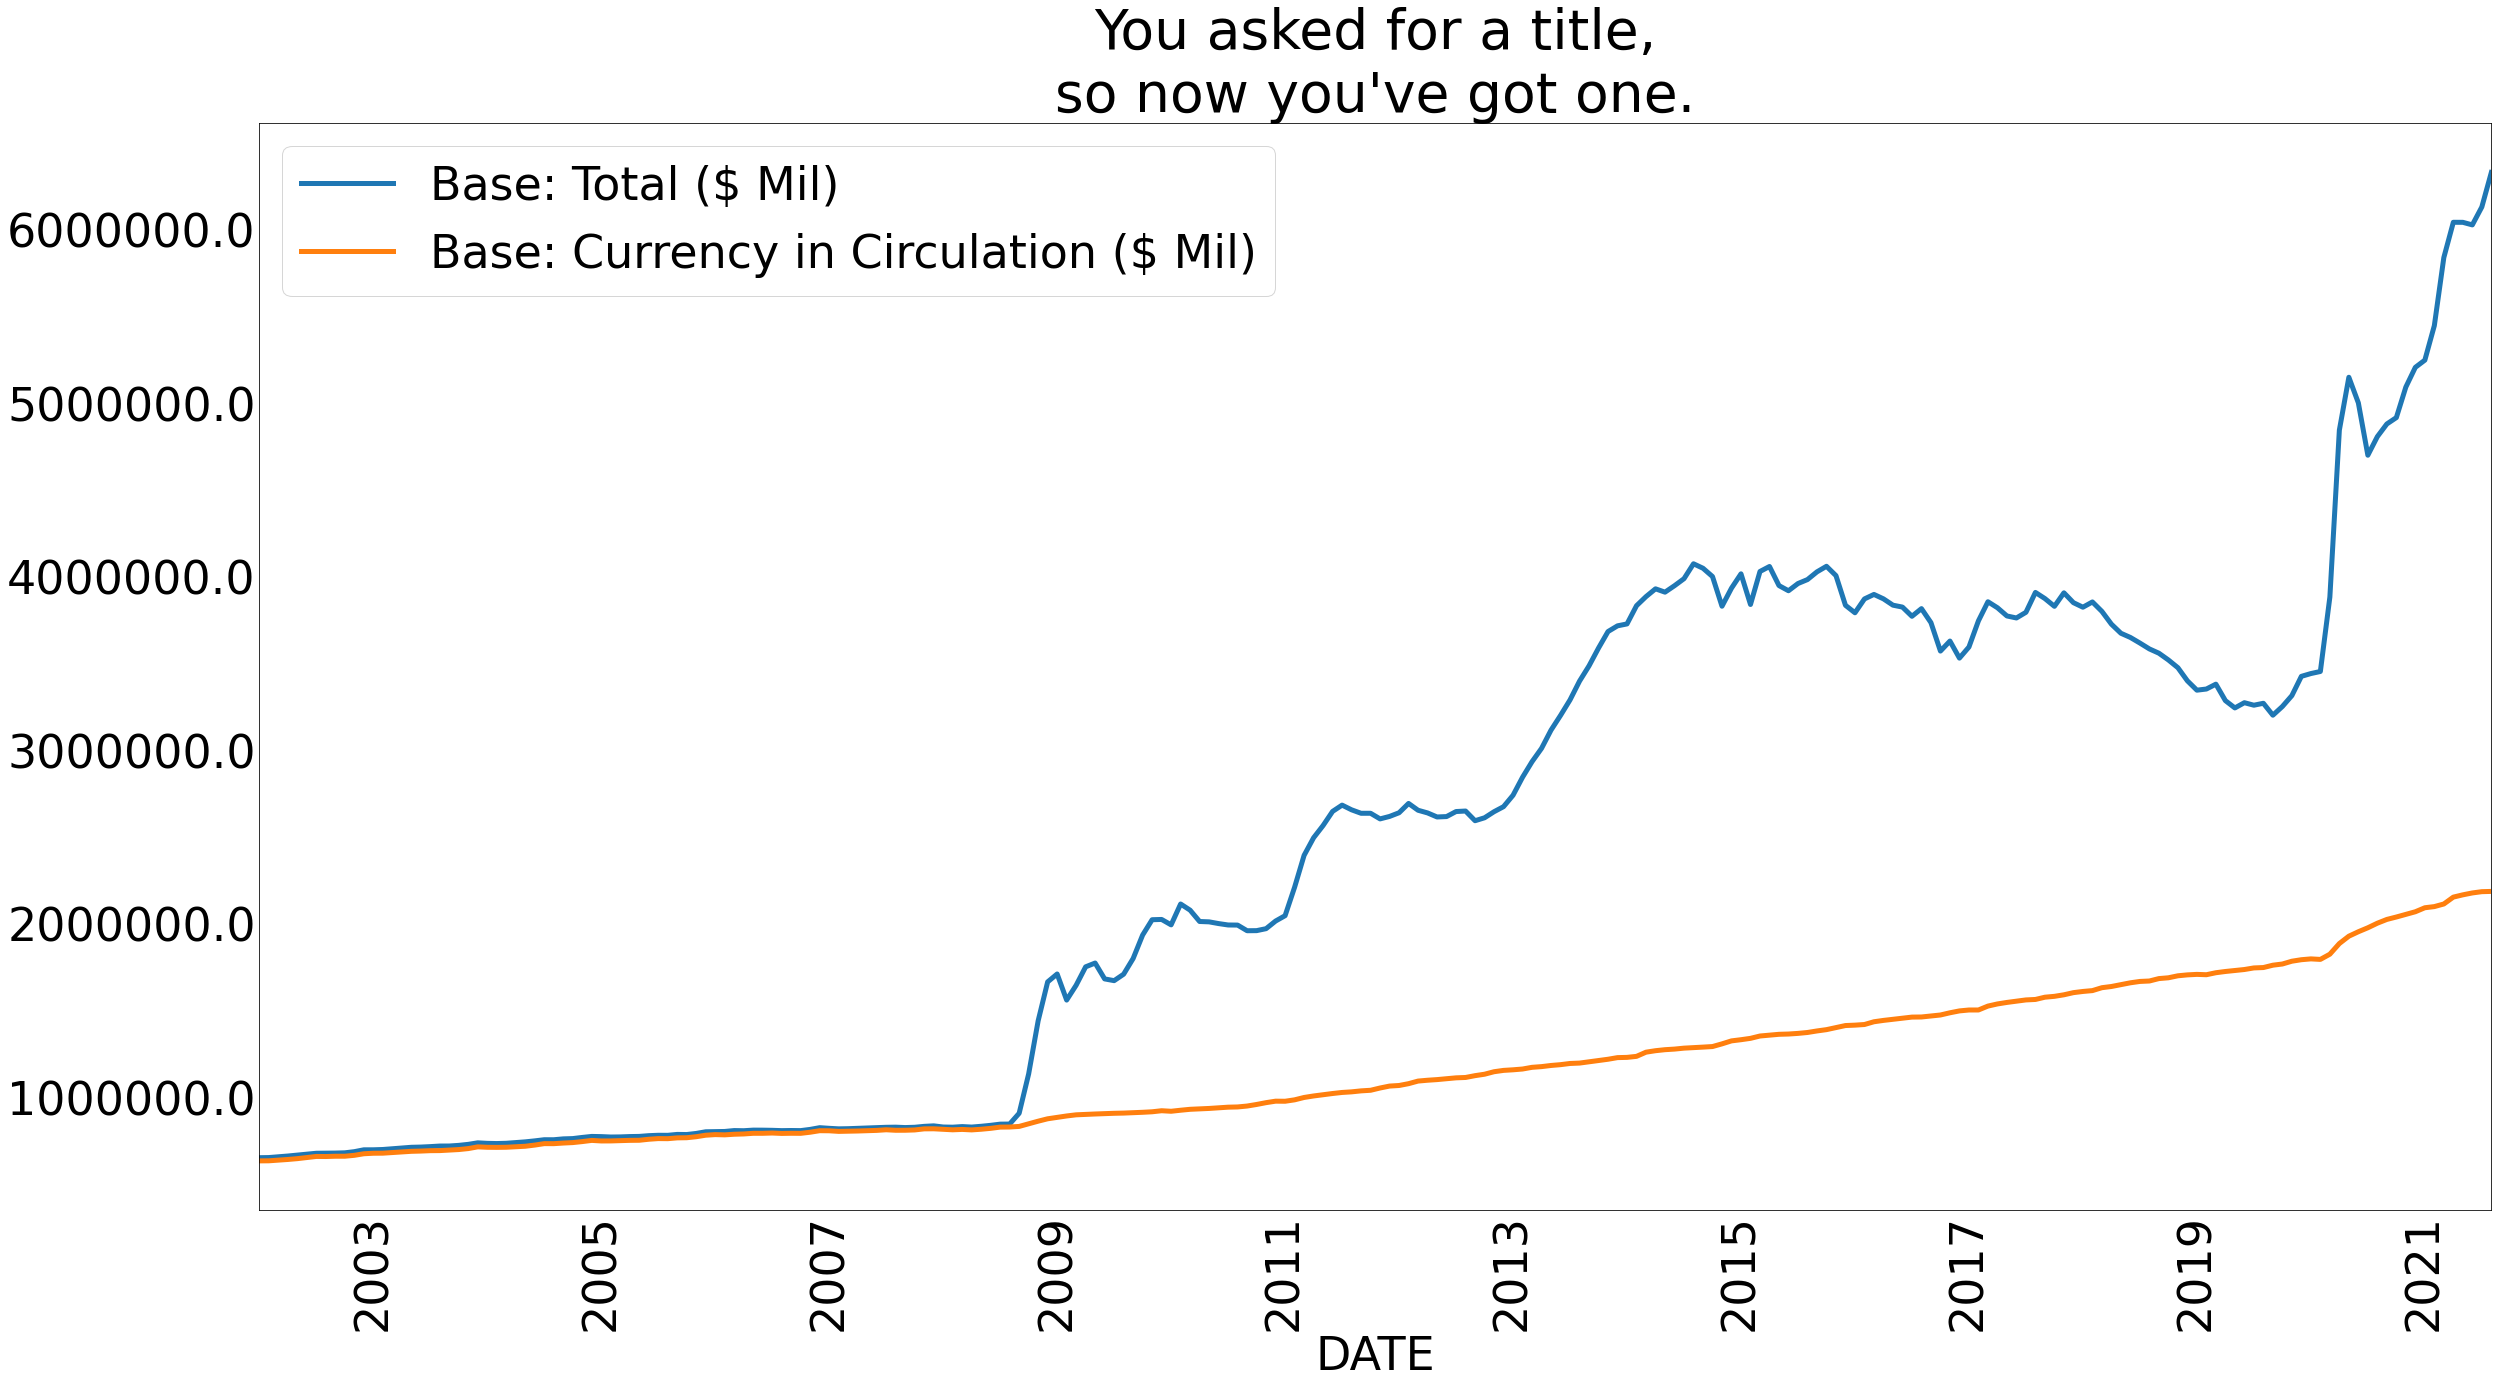

In [28]:
pp = PdfPages("Monetary Base Measures.pdf")

plt.rcParams.update({"font.size": 46})  
plot_vars = ["Base: Total ($ Mil)", 
             "Base: Currency in Circulation ($ Mil)"]
# create a dataframe with specific variables
plot_df = data[plot_vars]
plot_lines(plot_df, 
           title = "You asked for a title,\nso now you've got one.", 
           linewidth = 5,
          pp = pp)
pp.close()


In [29]:
def plot_stacked_lines(df,
                      plot_vars,
                      linewidth=1,
                      figsize = (40,20),
                      pp = None,
                      total_var = False):
    fig, ax = plt.subplots(figsize=figsize)
    df[plot_vars].plot.area(stacked = True,
                           linewidth = linewidth,
                           ax = ax)
    if total_var != False:
        df[total_var].plot.line(
            linewidth = linewidth,
            ax = ax,
            c = "k",
            label = total_var,
            ls = "--")
    ax.legend(loc=2, ncol = 2)
    if pp != None: pp.savefig(
                        fig,
                        bbox_inches = "tight")

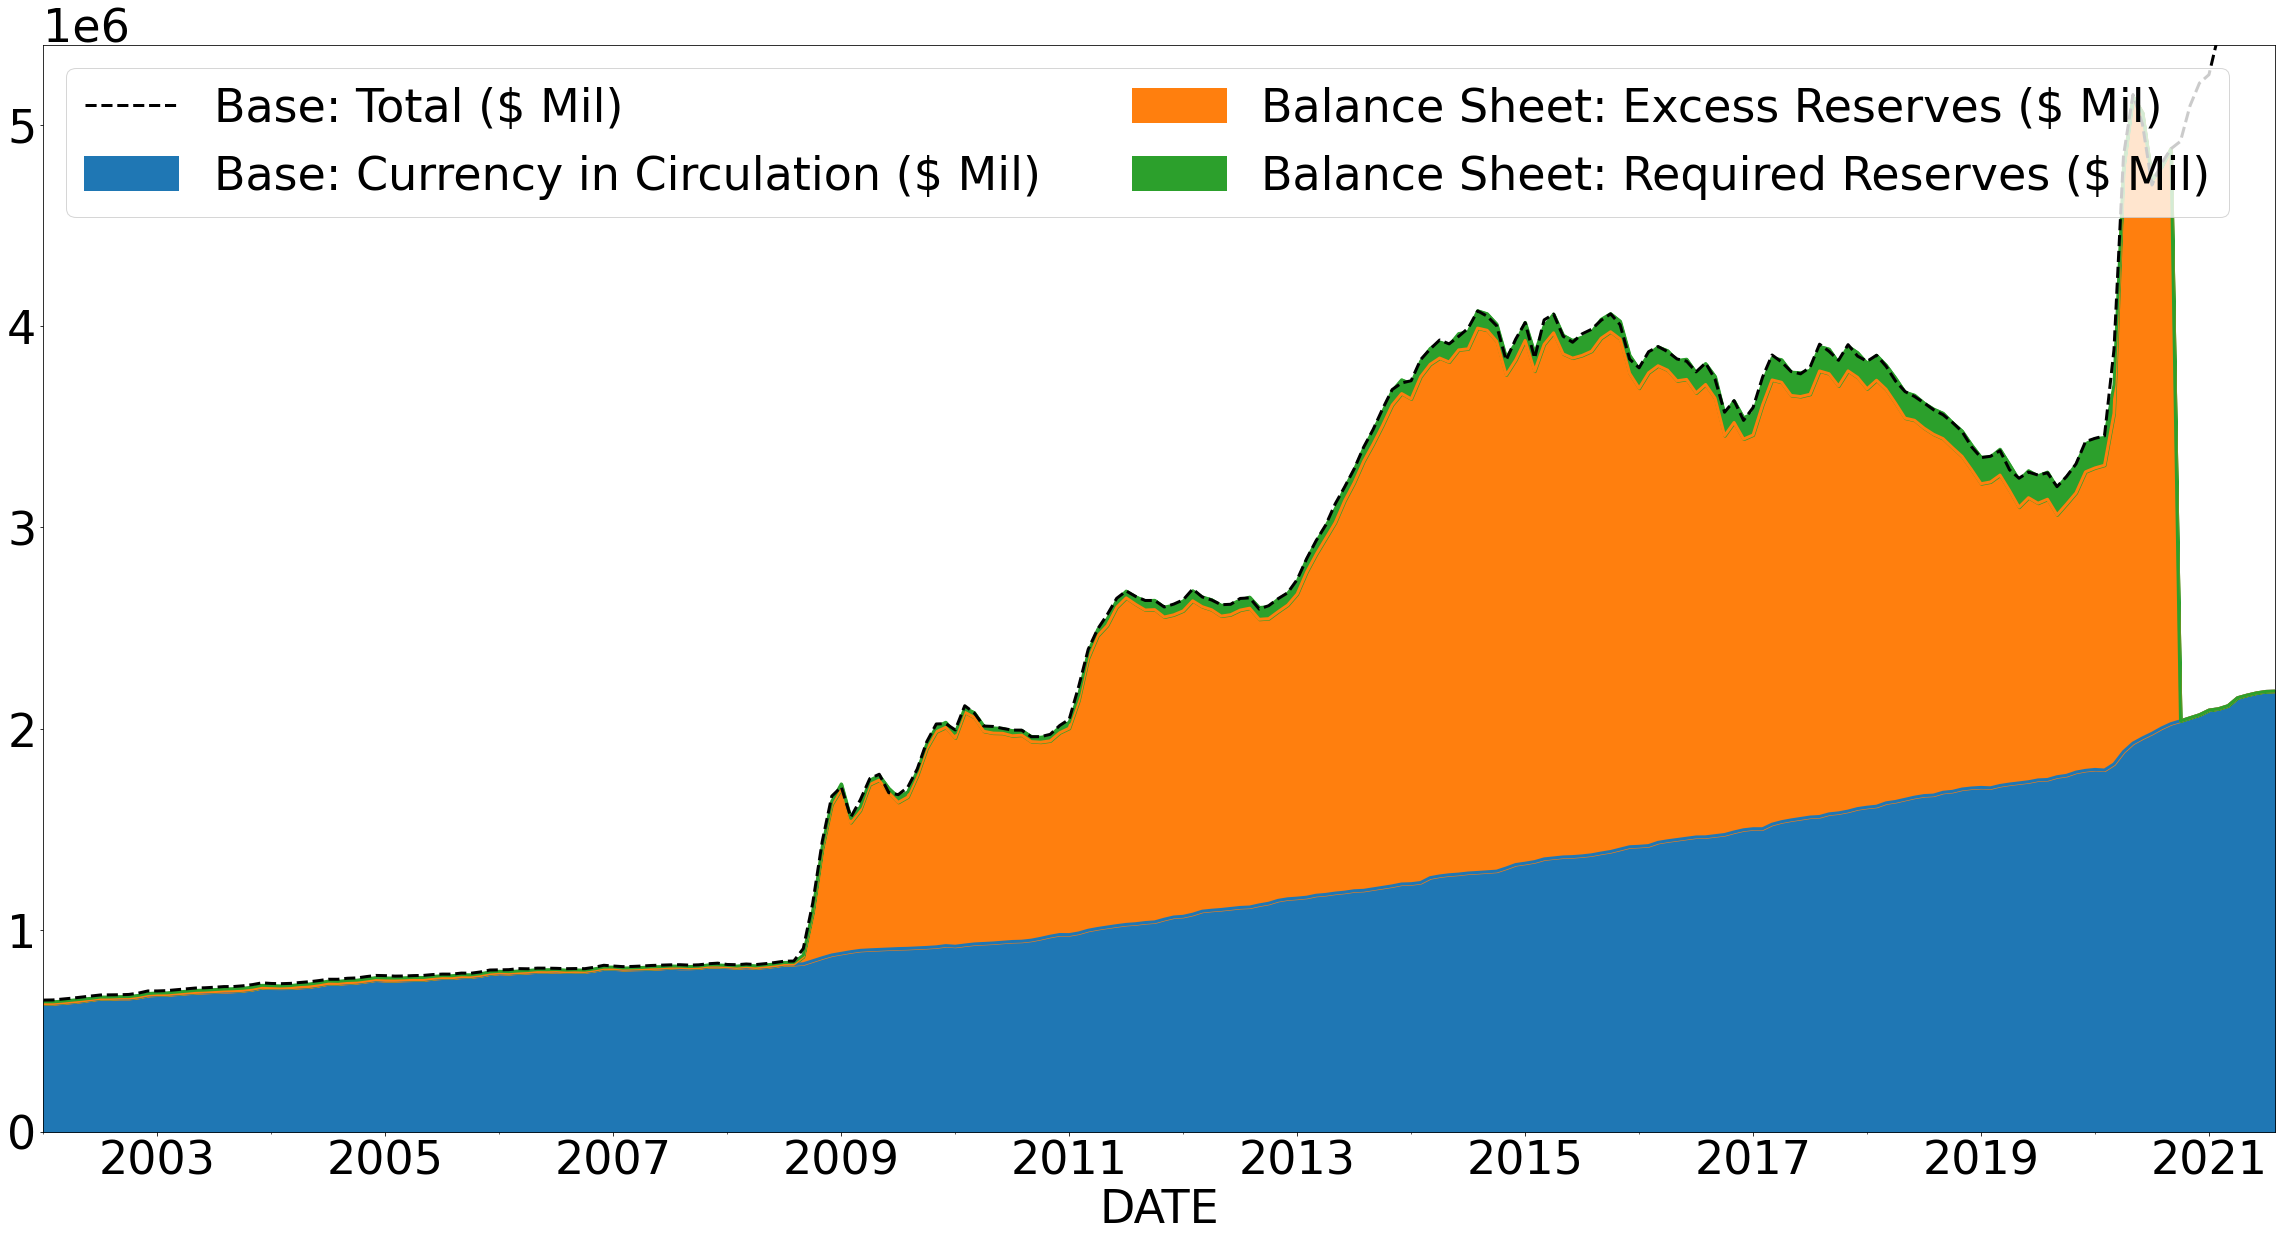

In [30]:
pp = PdfPages("stackedPlots.pdf")
money_vars = ["Base: Currency in Circulation ($ Mil)",
              "Balance Sheet: Excess Reserves ($ Mil)",
              "Balance Sheet: Required Reserves ($ Mil)"]

total_var = "Base: Total ($ Mil)"
plot_stacked_lines(data,
                  money_vars,
                  linewidth = 3,
                  total_var = total_var,
                  pp = pp)

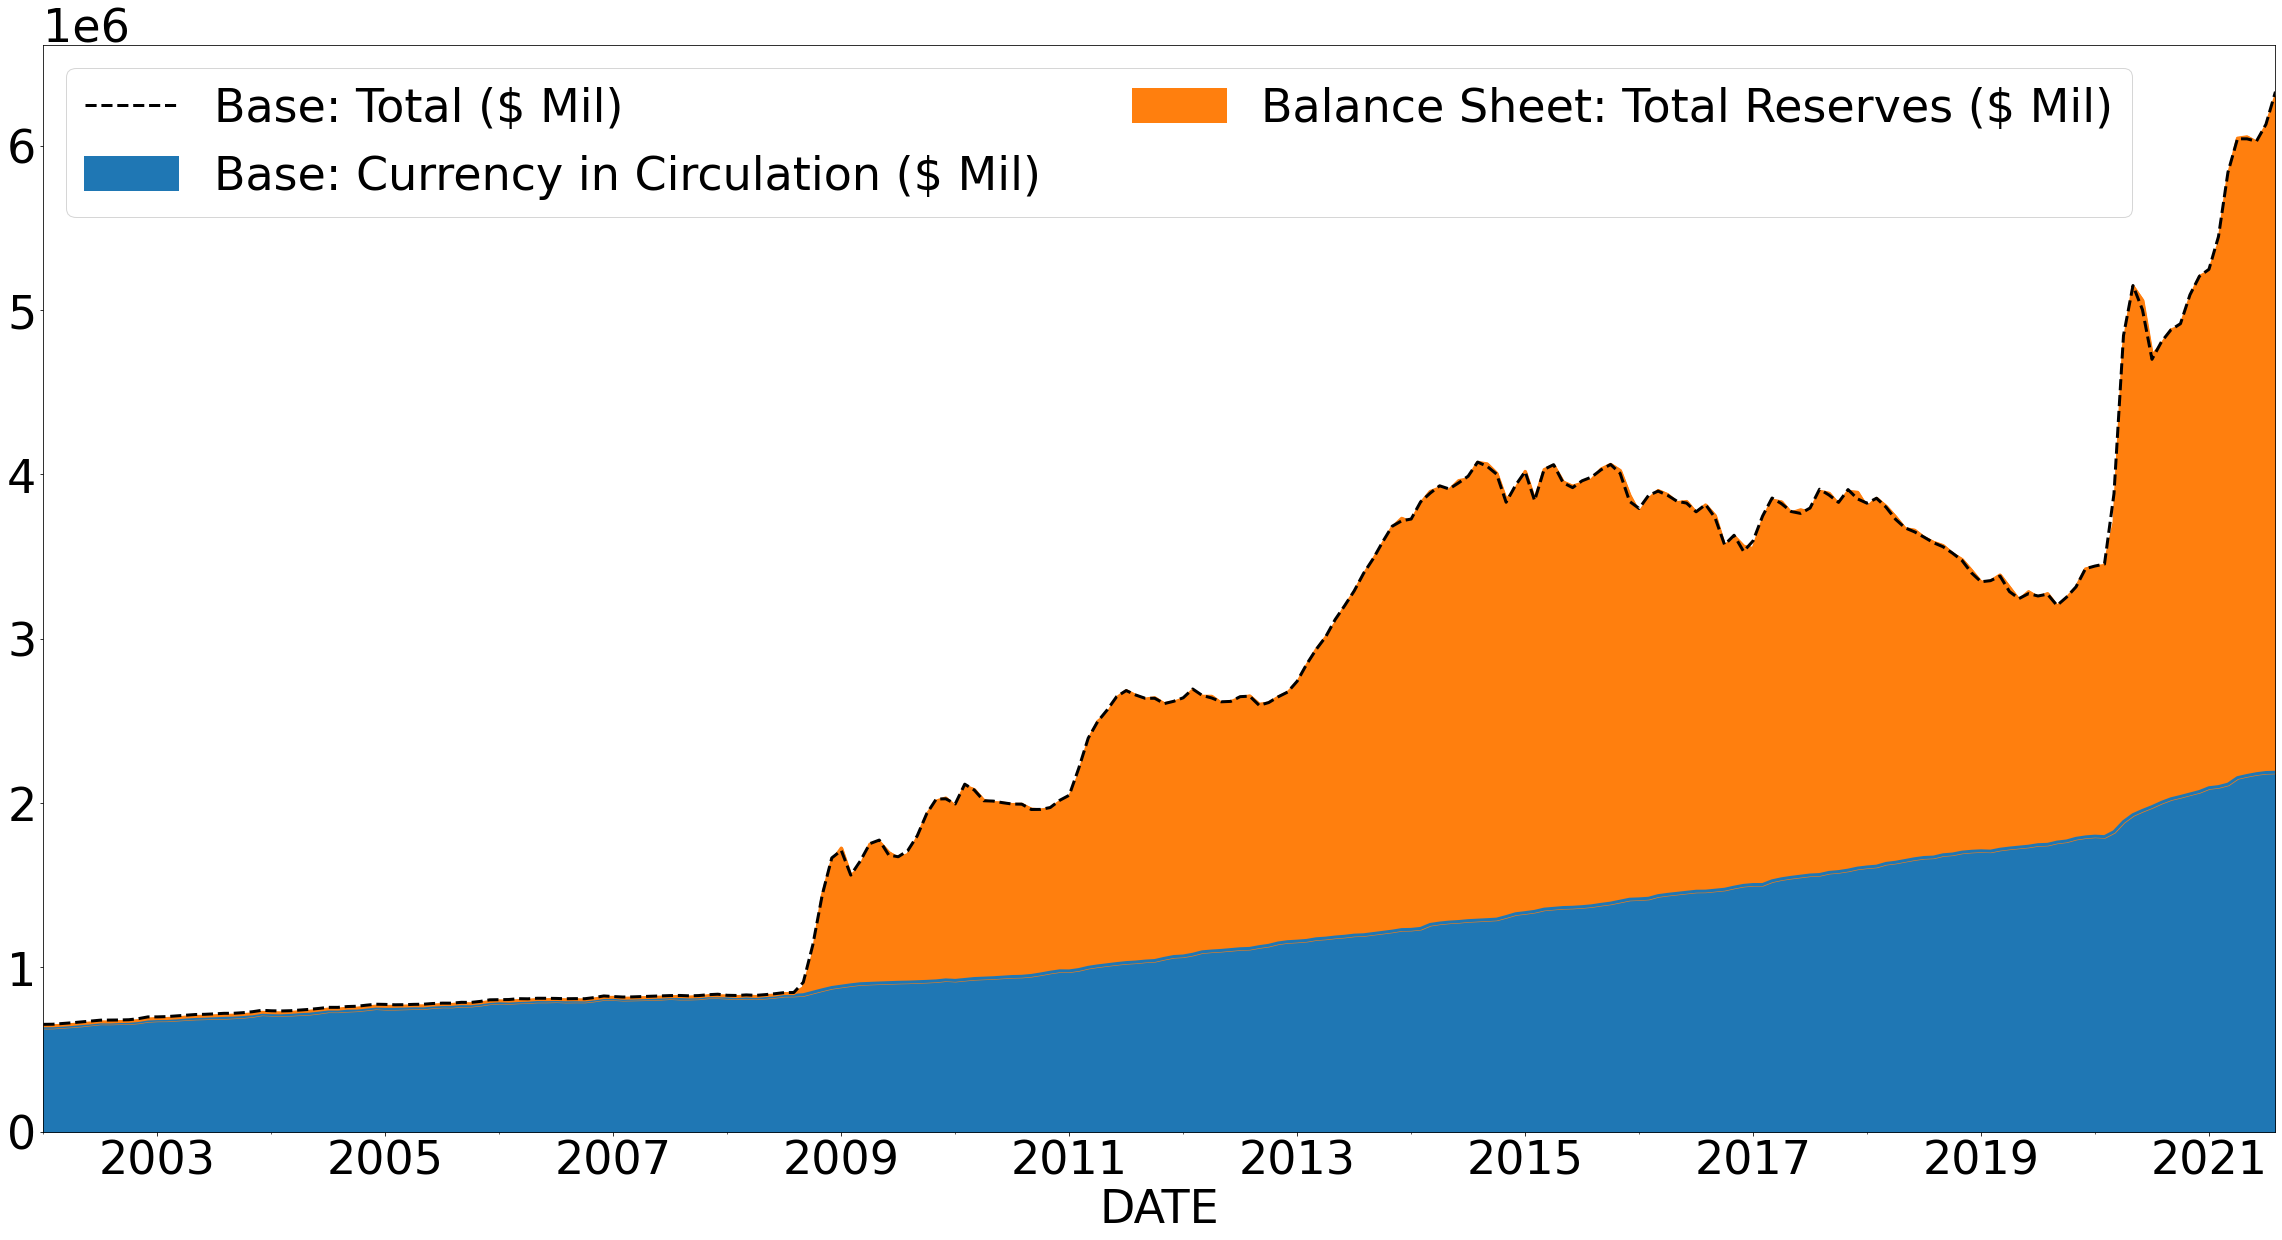

In [31]:
money_vars = ["Base: Currency in Circulation ($ Mil)",
              "Balance Sheet: Total Reserves ($ Mil)"]
total_var = "Base: Total ($ Mil)"
plot_stacked_lines(data,
                  money_vars,
                  linewidth = 3,
                  total_var = total_var,
                  pp = pp)

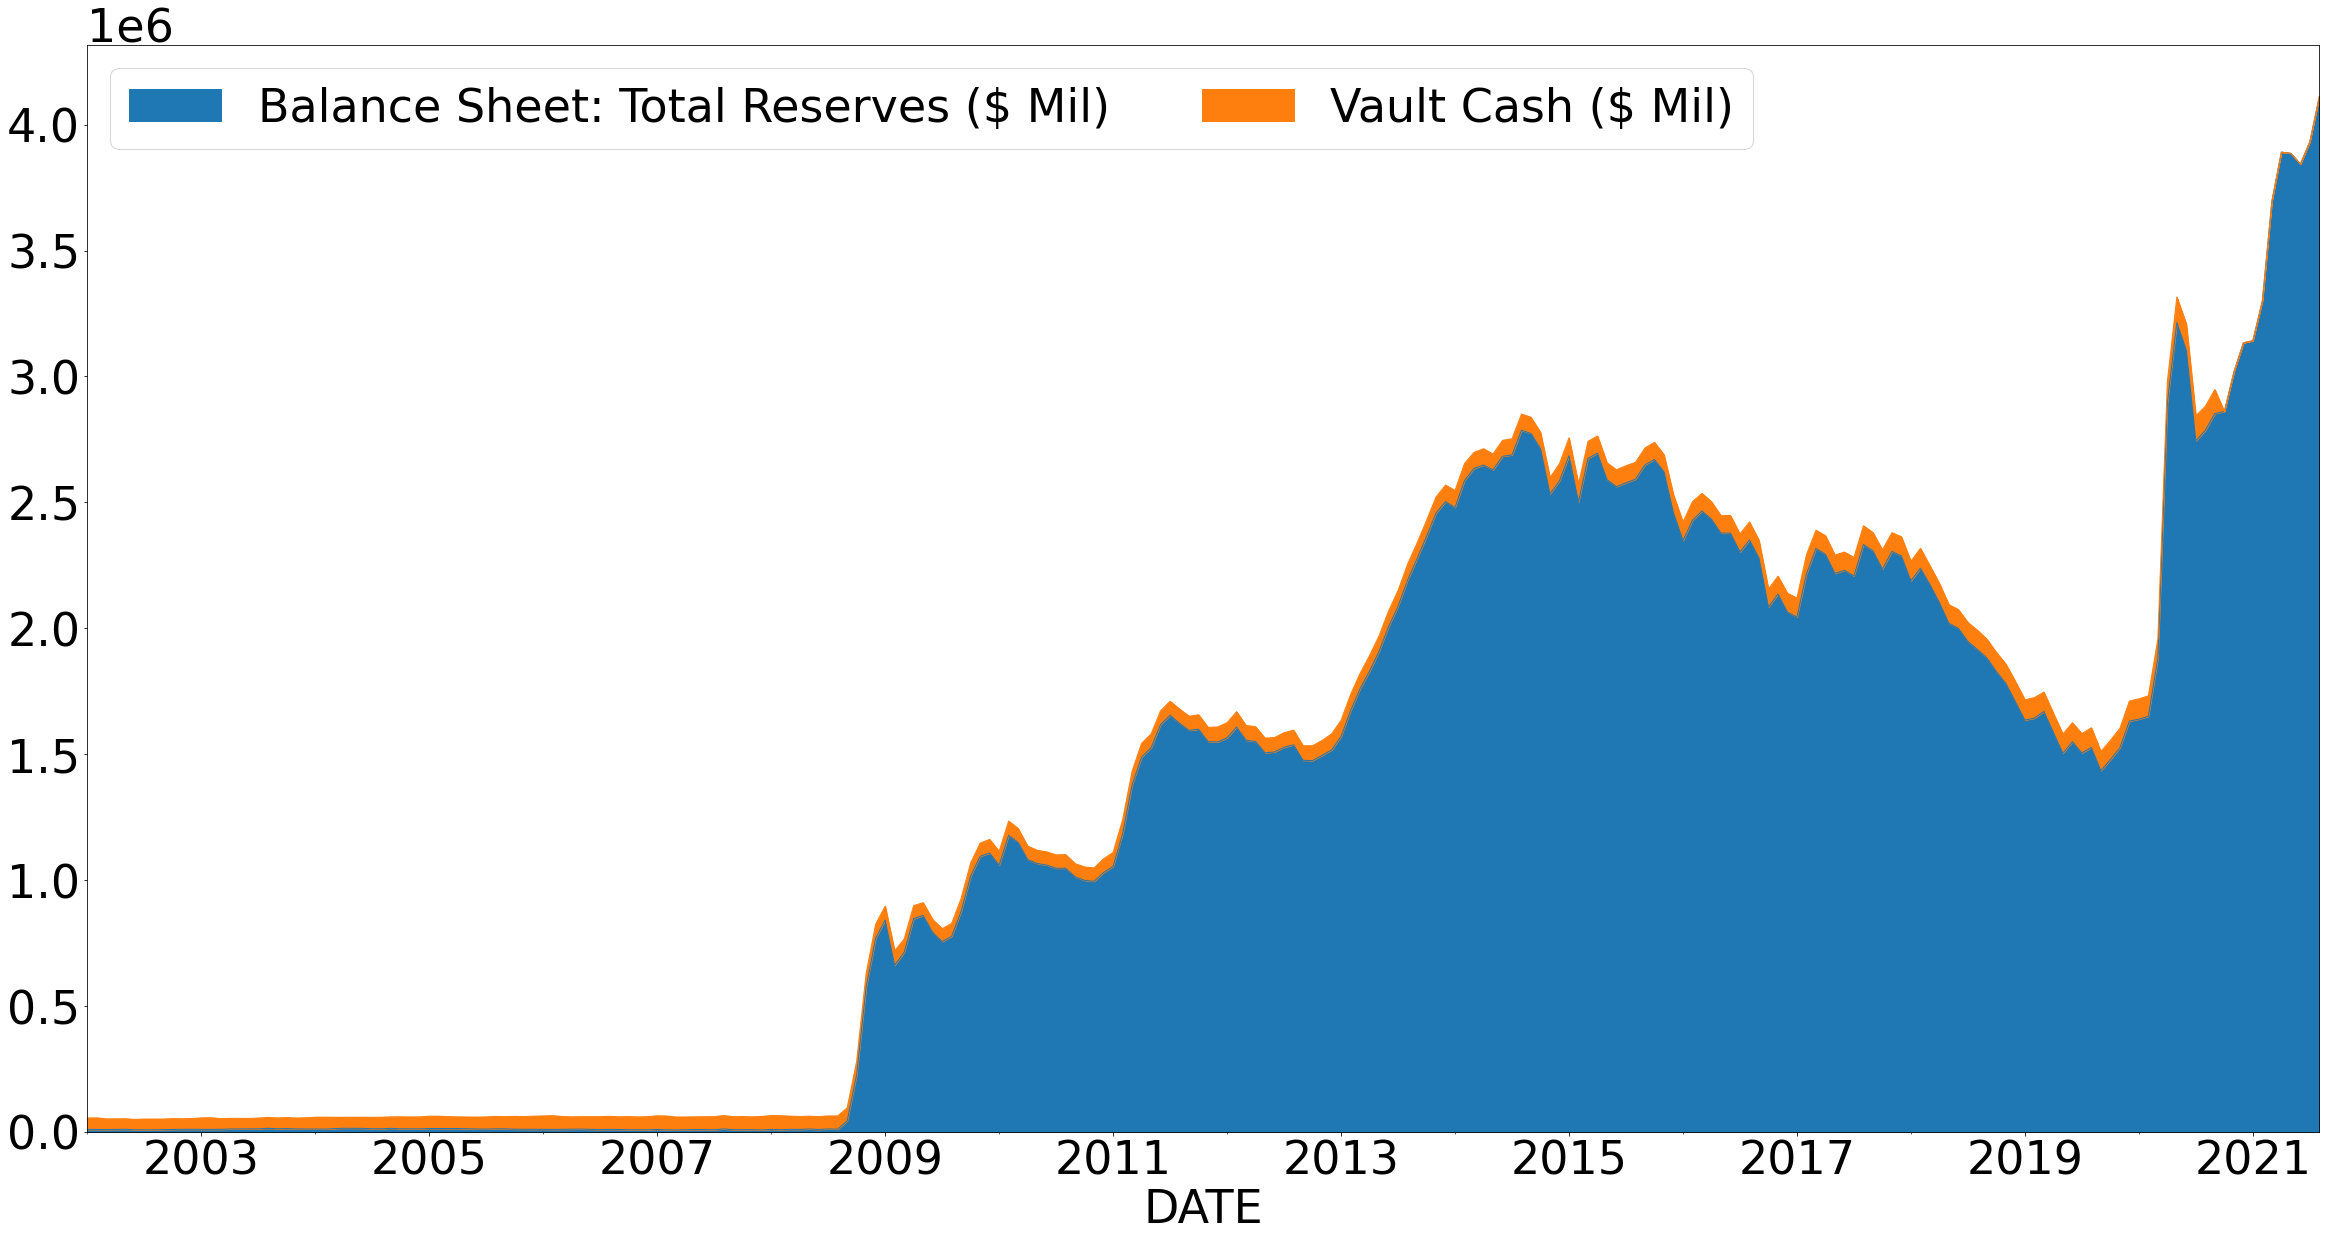

In [32]:
reserve_vars = ["Balance Sheet: Total Reserves ($ Mil)",
                "Vault Cash ($ Mil)"]
plot_stacked_lines(data, 
                   reserve_vars, 
                   pp = pp)

In [33]:
data["Vault Cash Used as Excess ($ Mil)"] = data["Vault Cash ($ Mil)"].sub(
    data["Vault Cash Used as Req. ($ Mil)"])

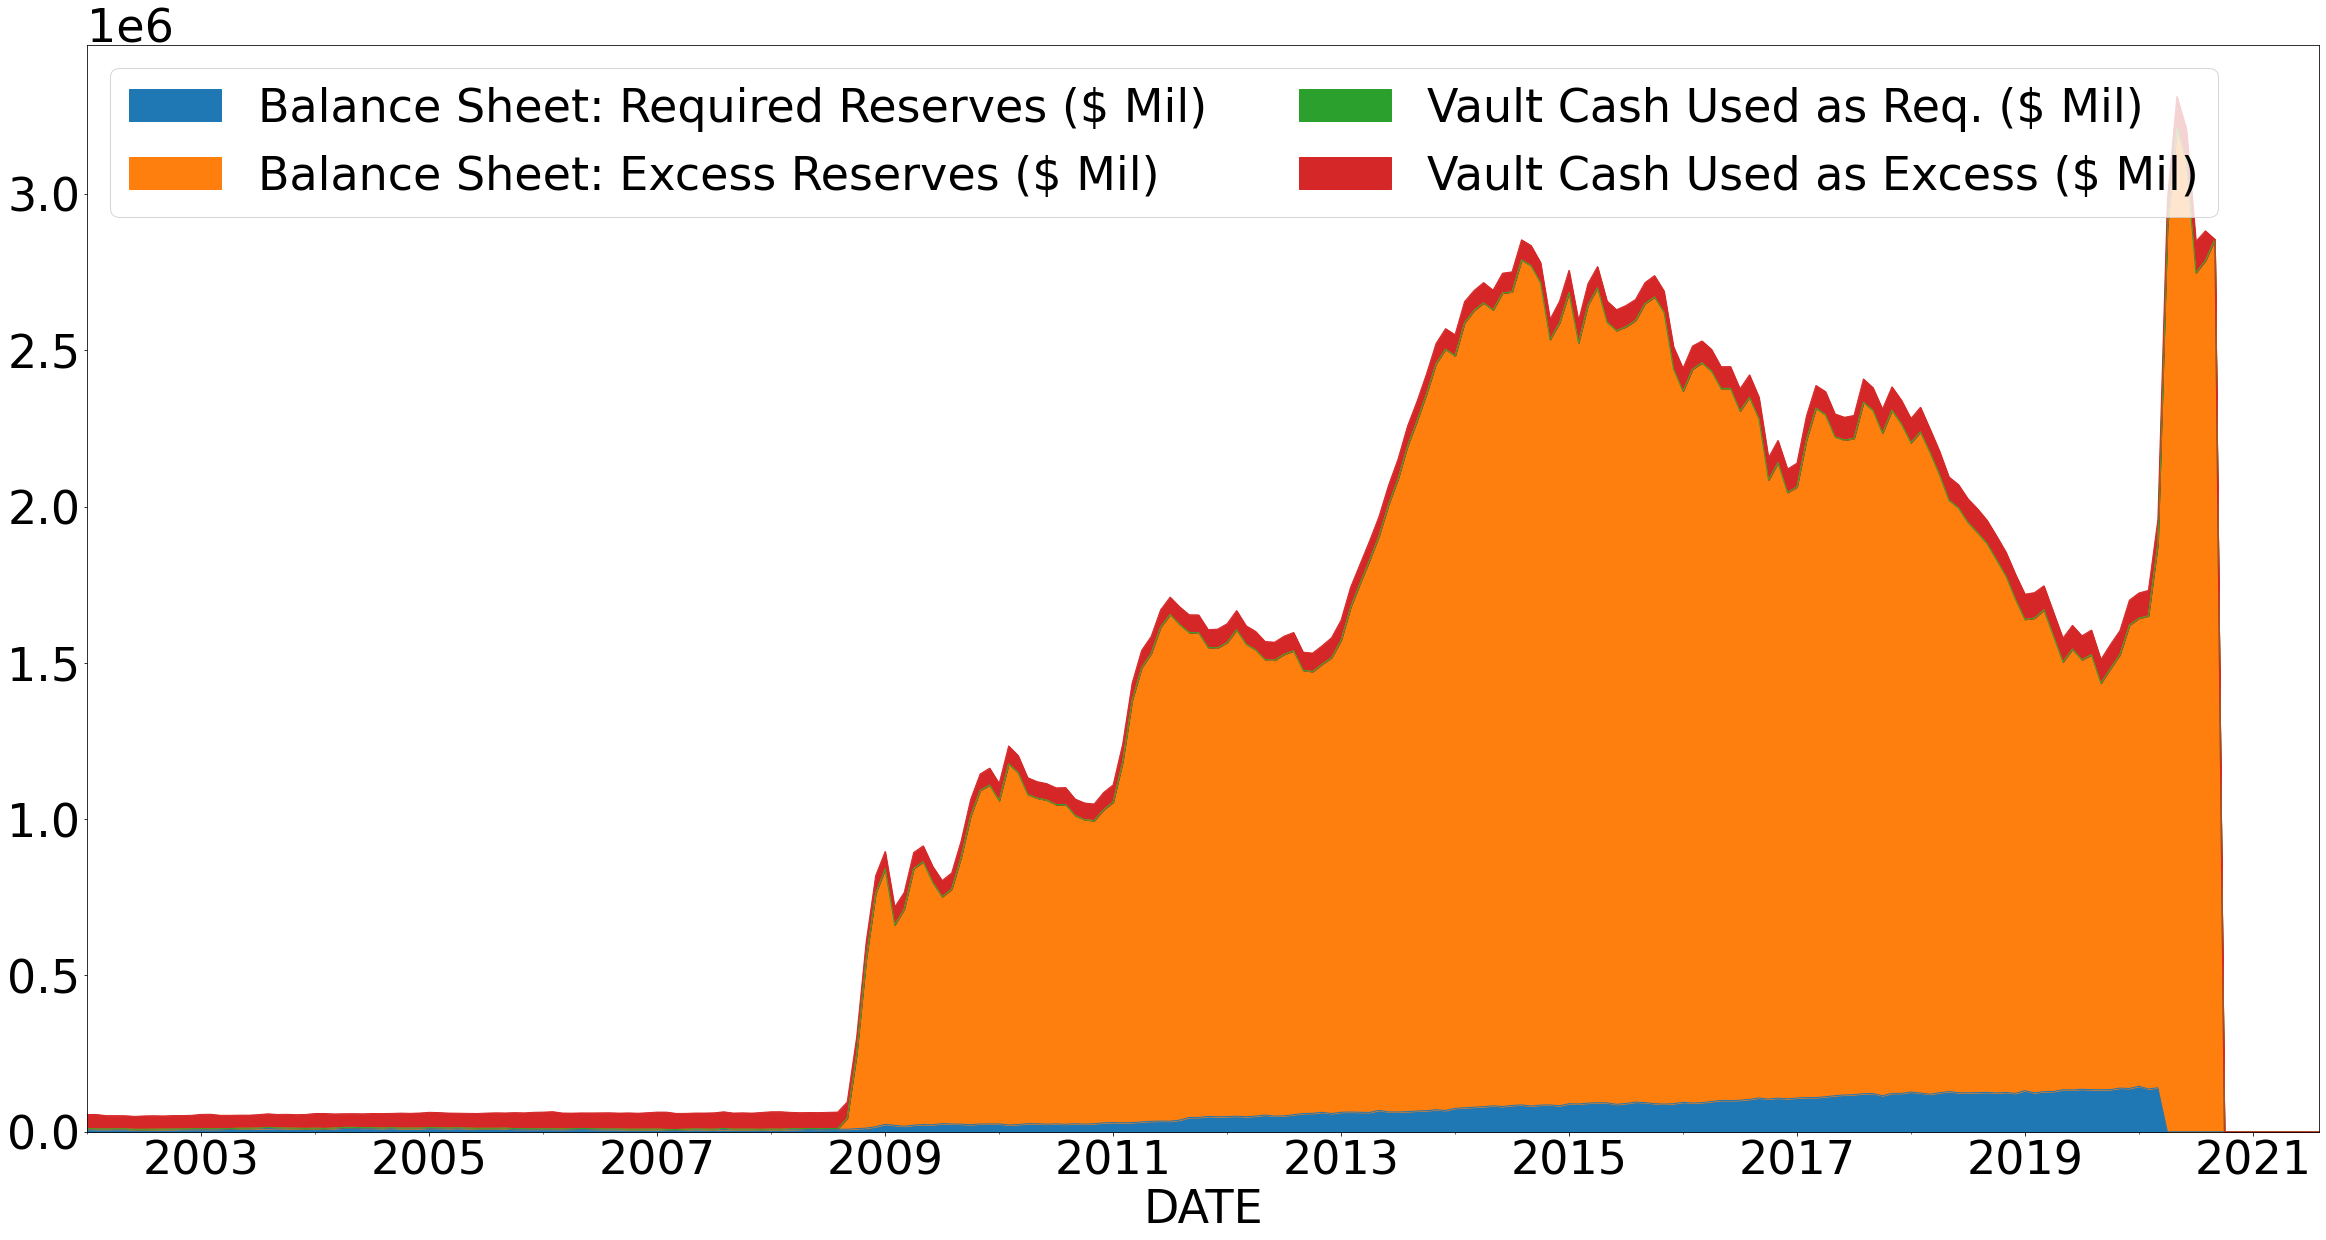

In [34]:
reserve_vars = ["Balance Sheet: Required Reserves ($ Mil)",
                "Balance Sheet: Excess Reserves ($ Mil)",
                "Vault Cash Used as Req. ($ Mil)",
                "Vault Cash Used as Excess ($ Mil)",]
plot_stacked_lines(data, reserve_vars)

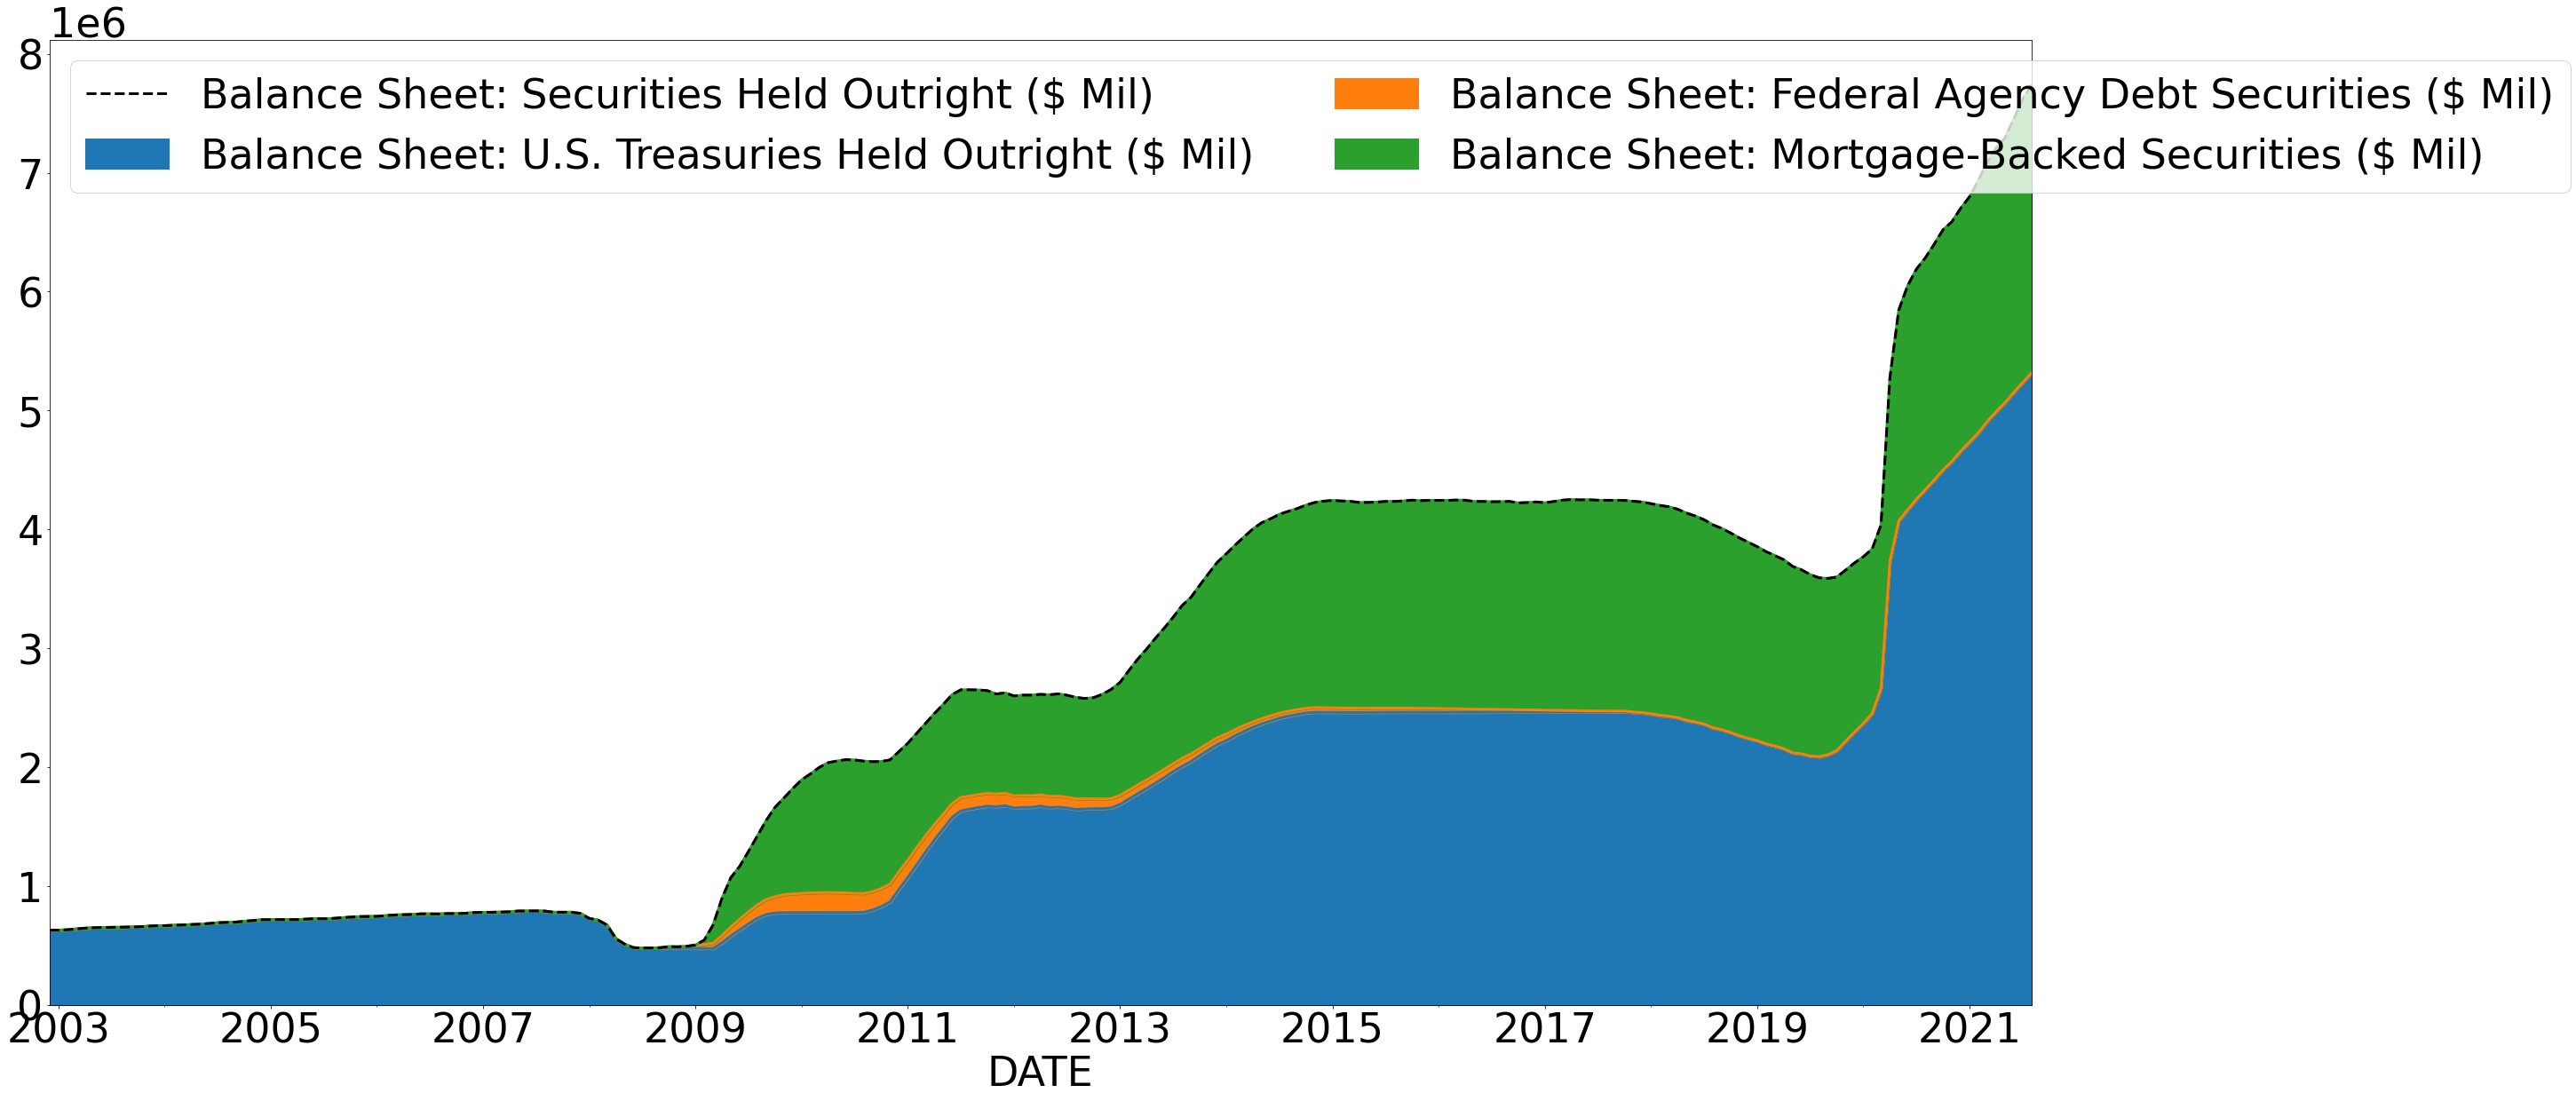

In [39]:
asset_vars = ["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)",
             "Balance Sheet: Federal Agency Debt Securities ($ Mil)",
             "Balance Sheet: Mortgage-Backed Securities ($ Mil)"]
plot_stacked_lines(data.loc["2002-12-31":],
                   asset_vars, linewidth = 3,
                   total_var = "Balance Sheet: Securities Held Outright ($ Mil)",
                   pp = pp,)

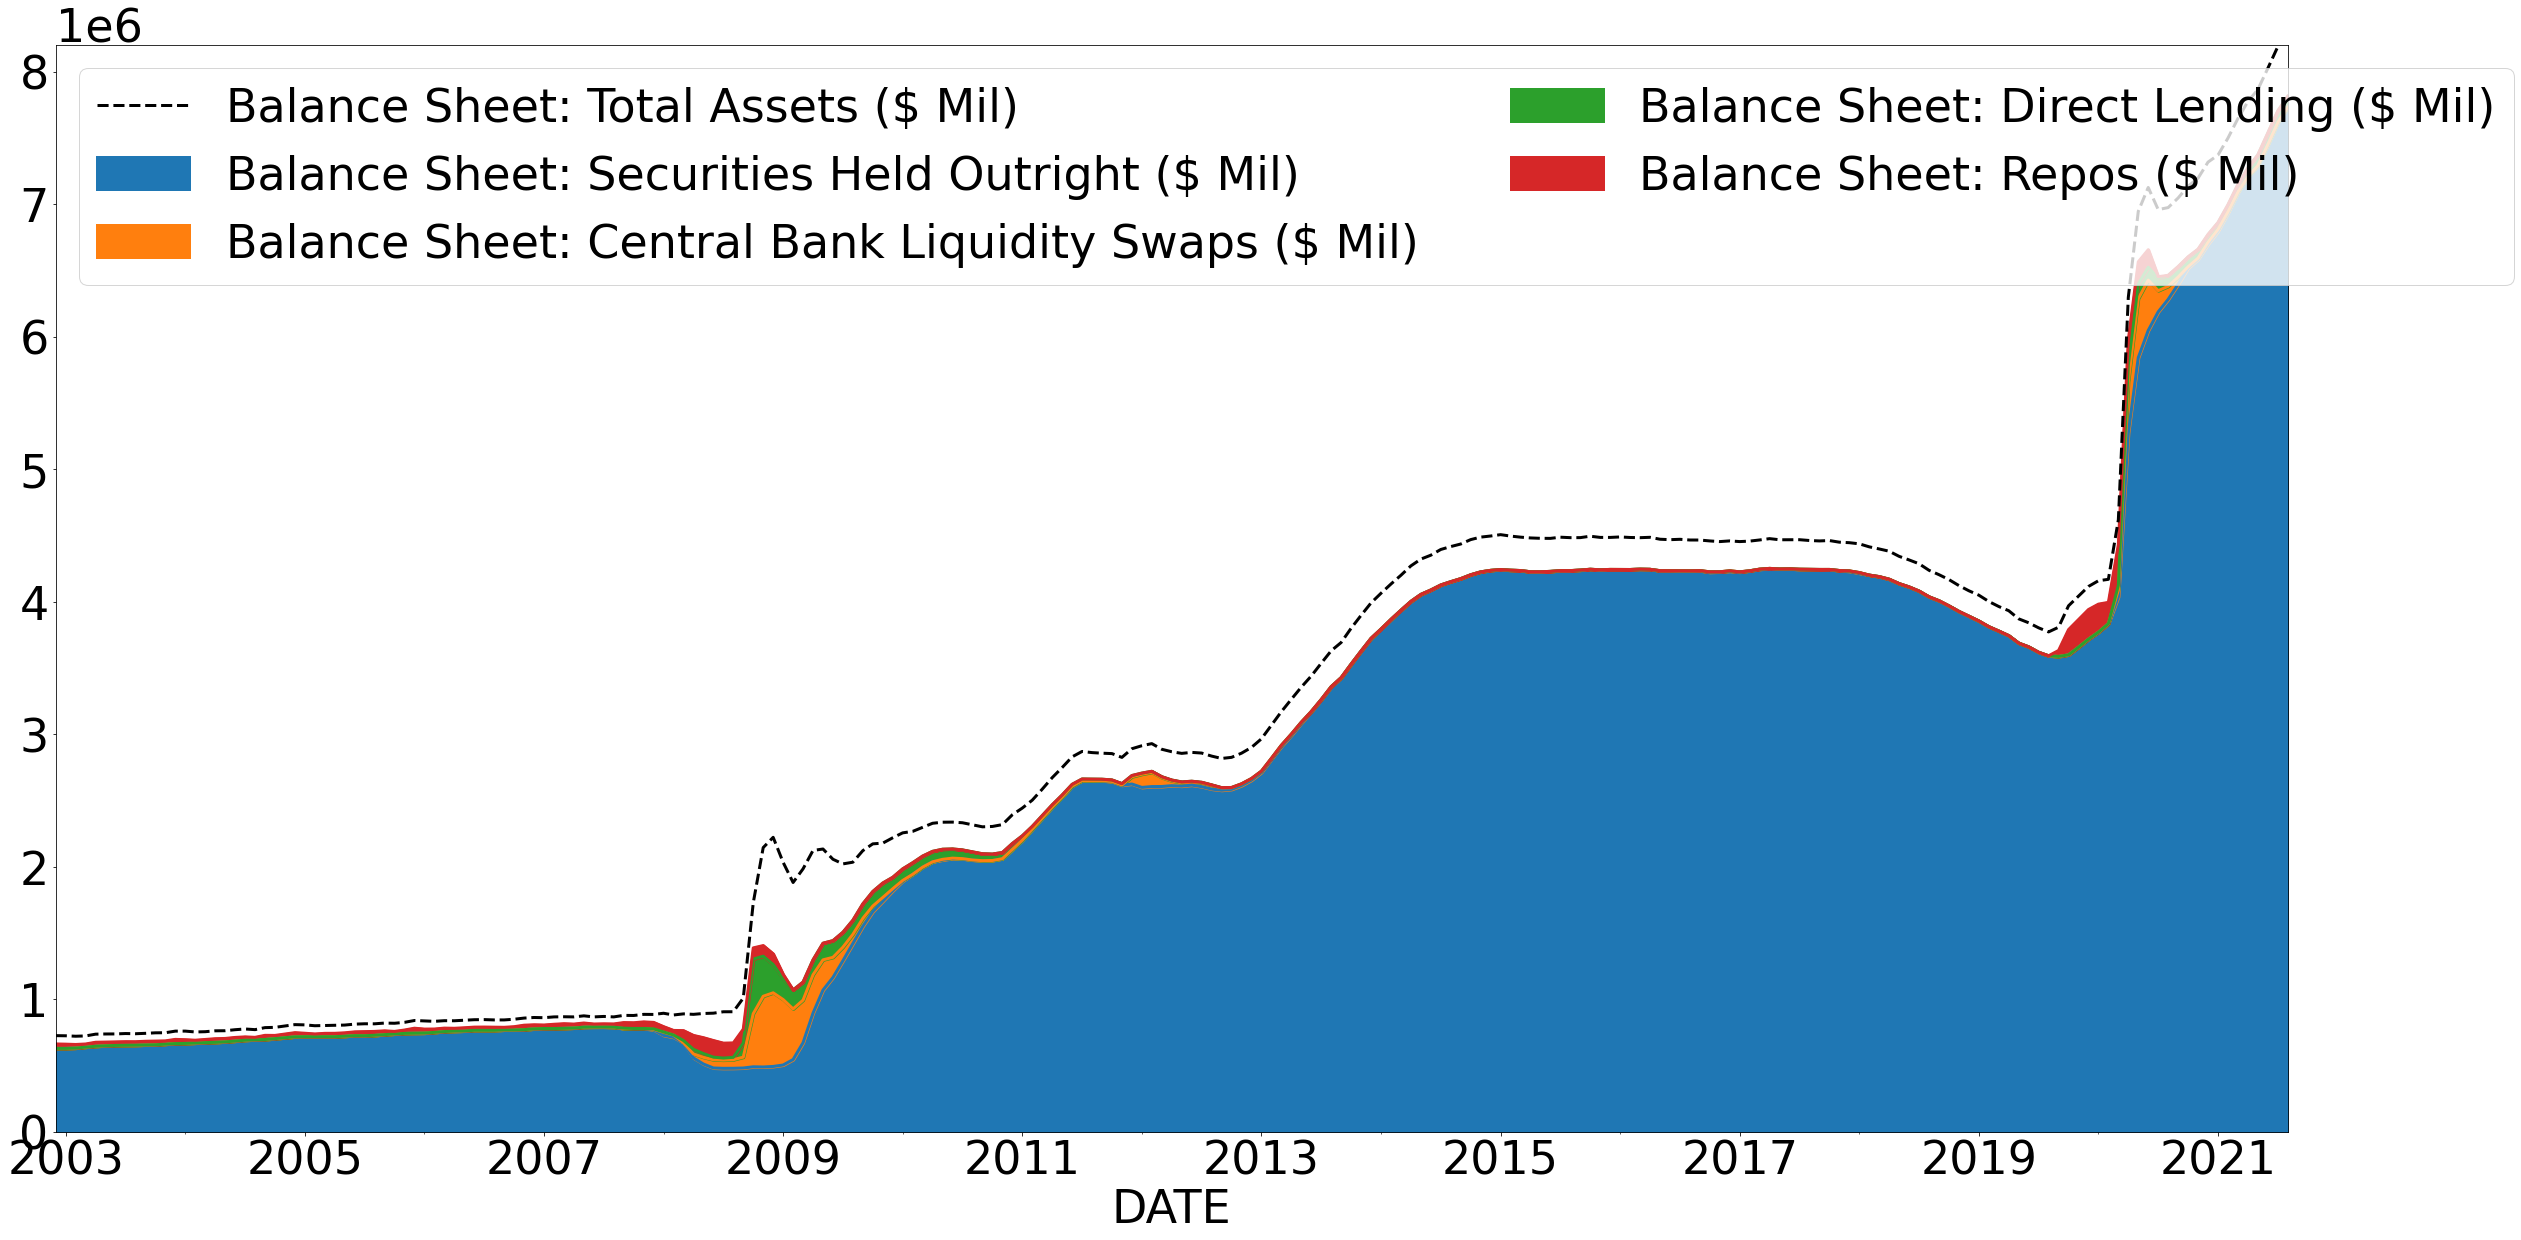

In [40]:
asset_vars = ["Balance Sheet: Securities Held Outright ($ Mil)",
              "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)",
              "Balance Sheet: Direct Lending ($ Mil)",
              "Balance Sheet: Repos ($ Mil)"]
plot_stacked_lines(data.loc["2002-12-31":],
                   asset_vars,
                   linewidth = 3, 
                   total_var = "Balance Sheet: Total Assets ($ Mil)")

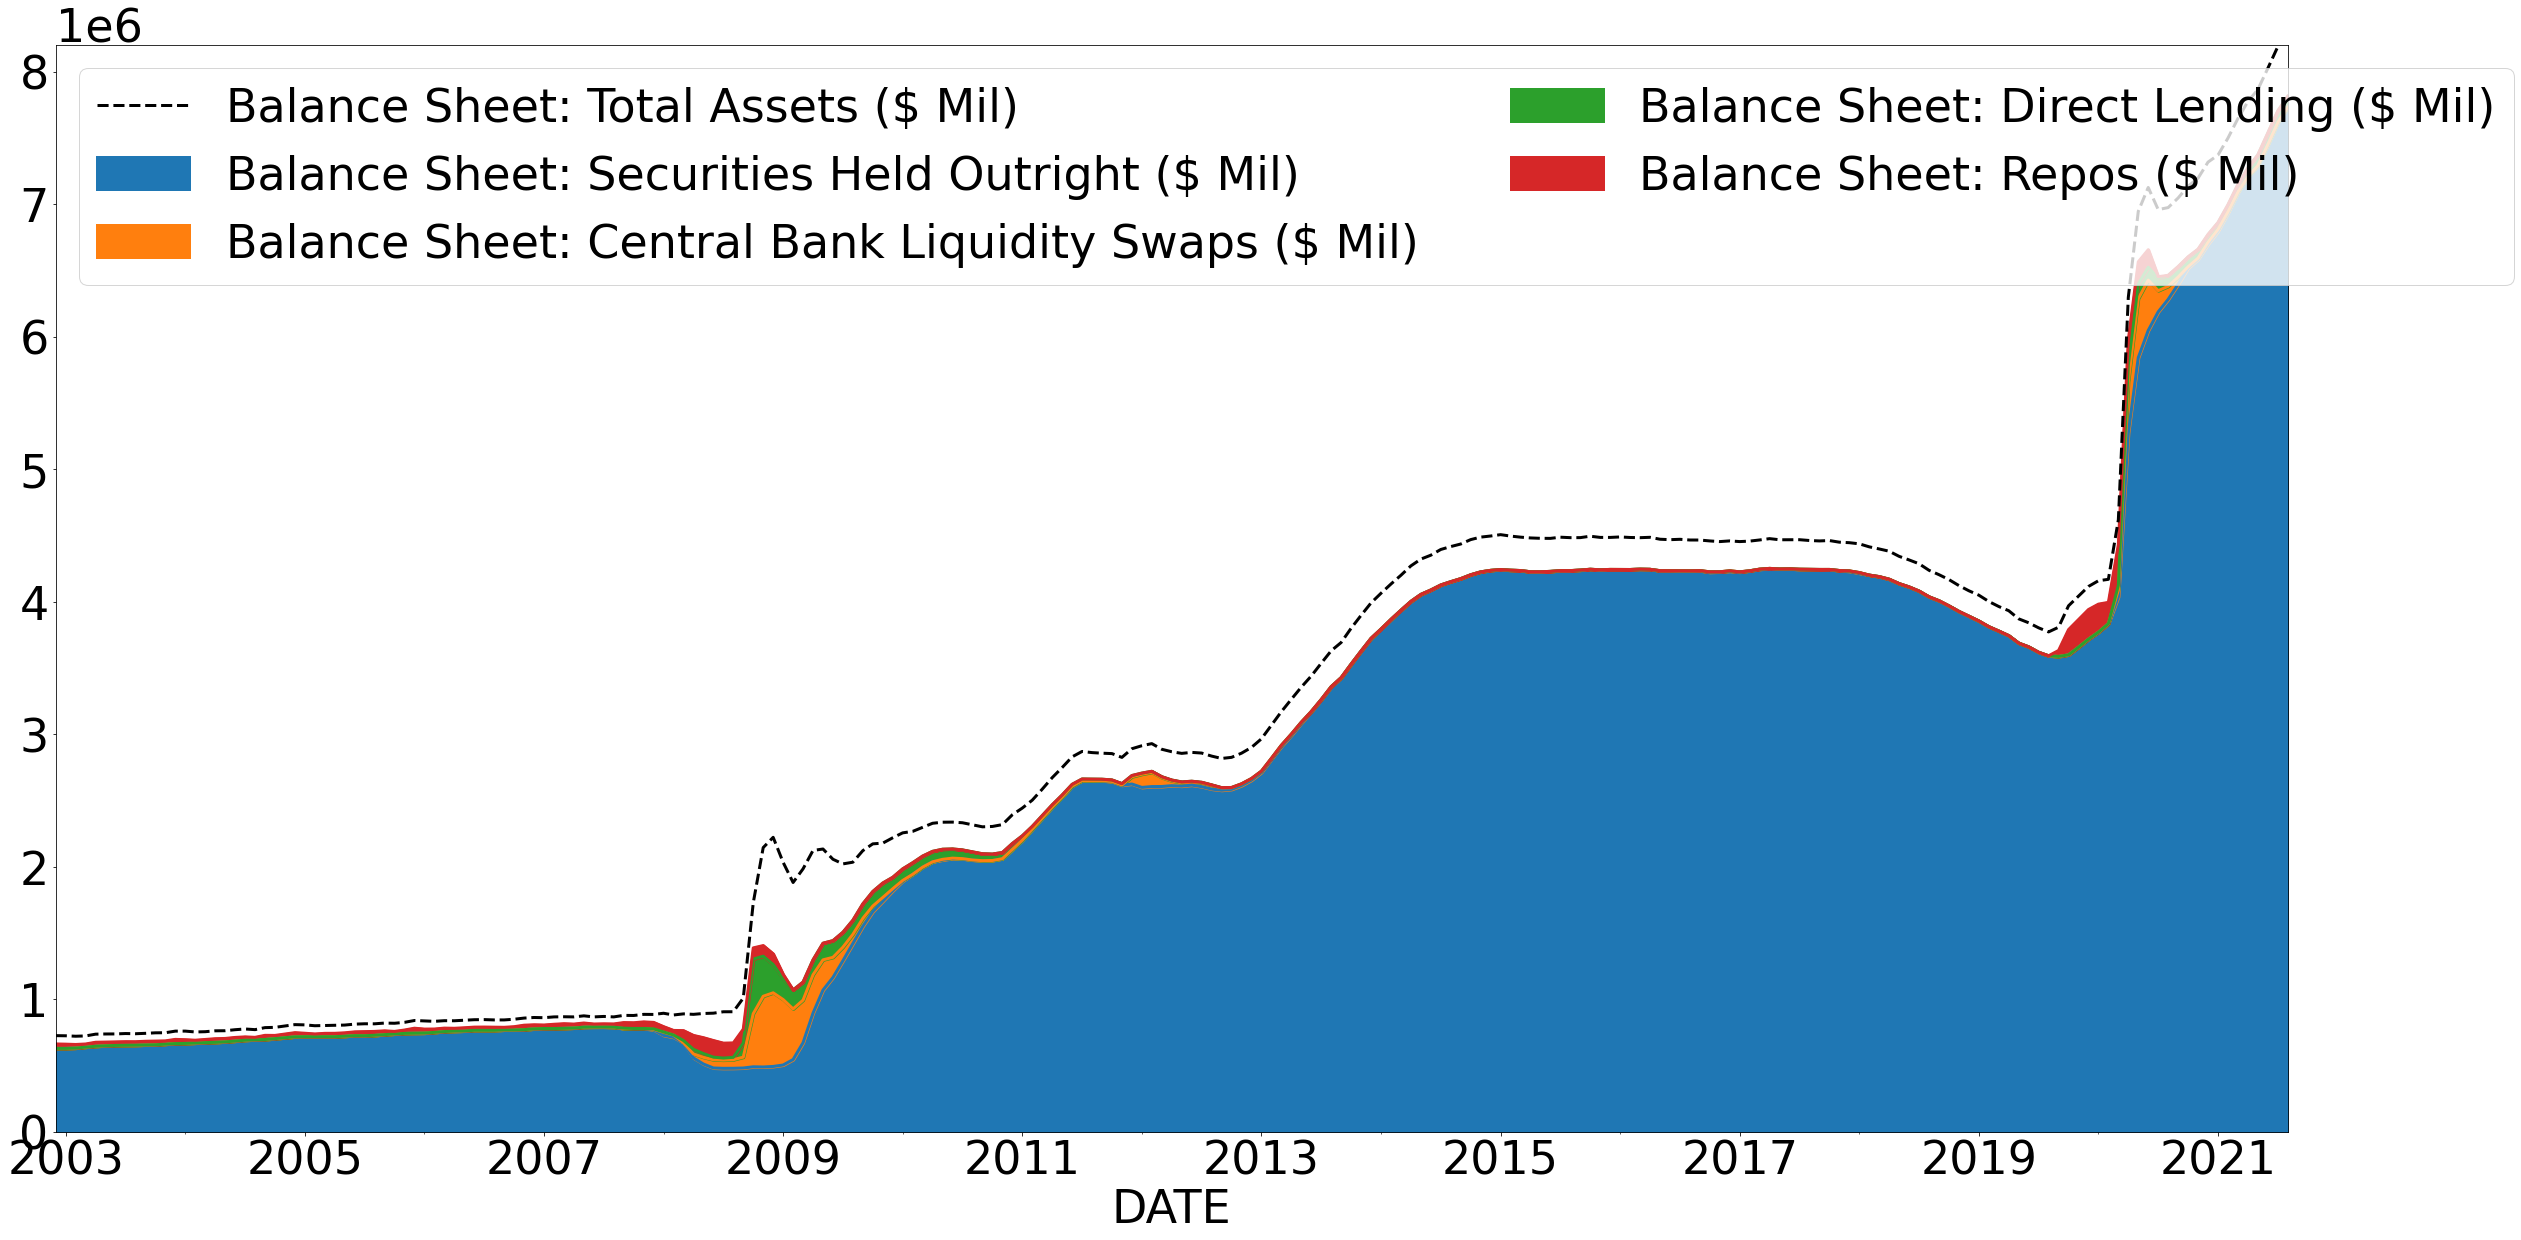

In [41]:
asset_vars = ["Balance Sheet: Securities Held Outright ($ Mil)",
              "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)",
              "Balance Sheet: Direct Lending ($ Mil)",
              "Balance Sheet: Repos ($ Mil)"]
plot_stacked_lines(data.loc["2002-12-31":],
                   asset_vars,
                   linewidth = 3, 
                   total_var = "Balance Sheet: Total Assets ($ Mil)")

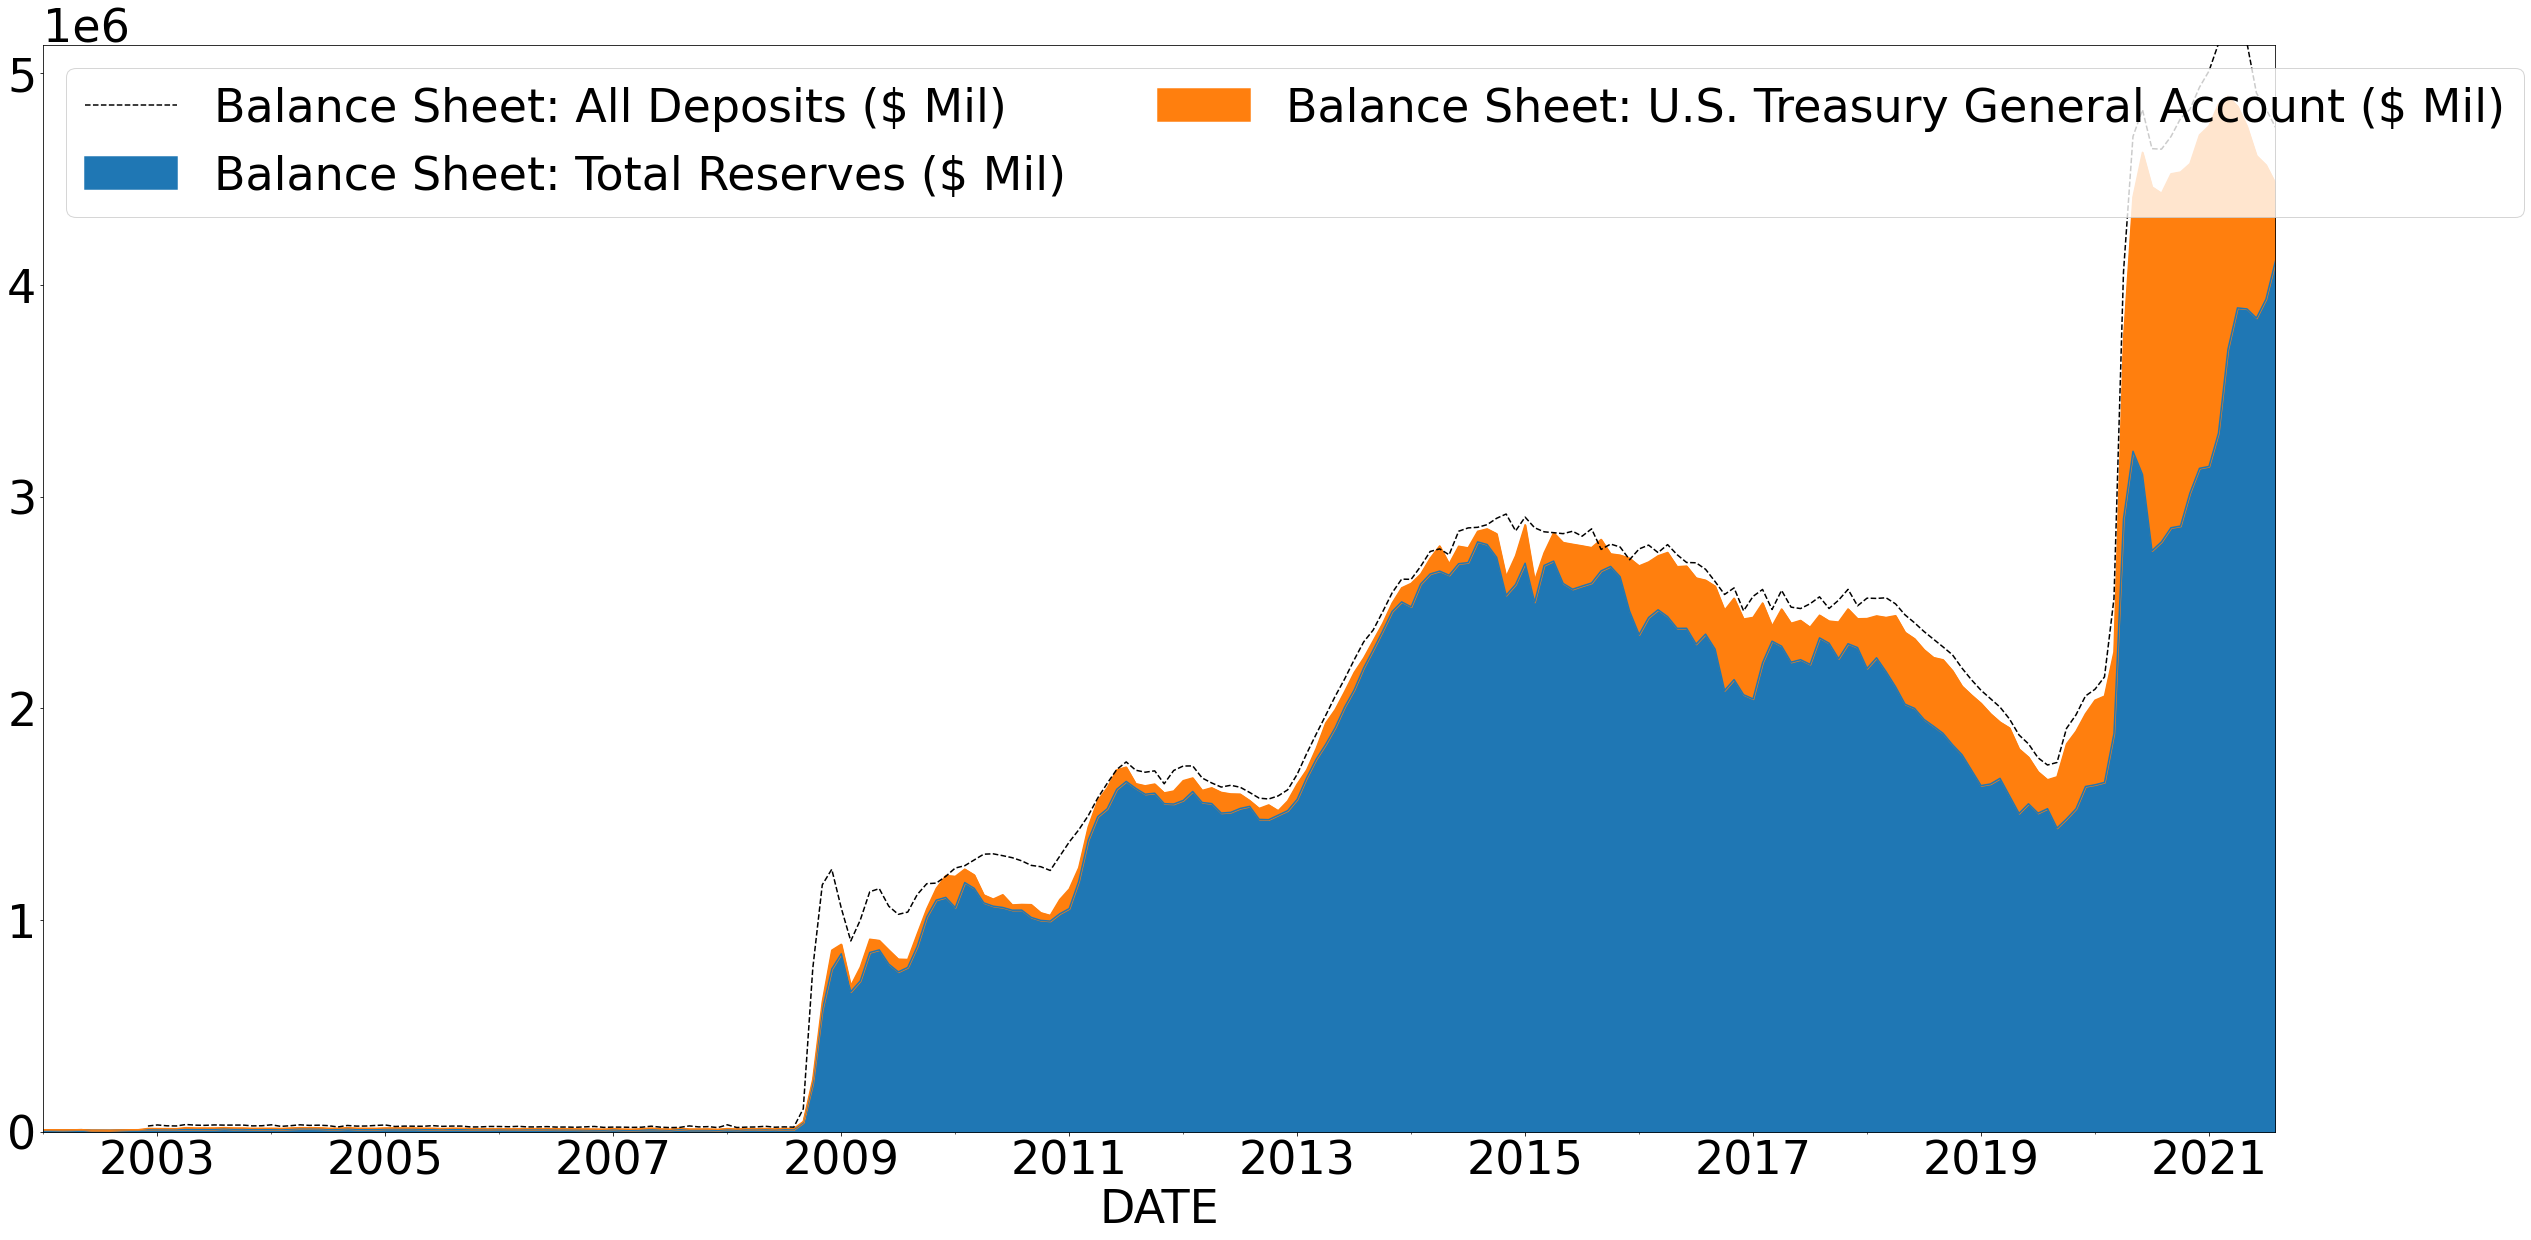

In [42]:
#fedProject
# . . . 
account_vars = ["Balance Sheet: Total Reserves ($ Mil)",
                "Balance Sheet: U.S. Treasury General Account ($ Mil)"]

plot_stacked_lines(data, account_vars, 
                   linewidth = 1.5, 
                   total_var = "Balance Sheet: All Deposits ($ Mil)", 
                   pp = pp,)

# Liabilities

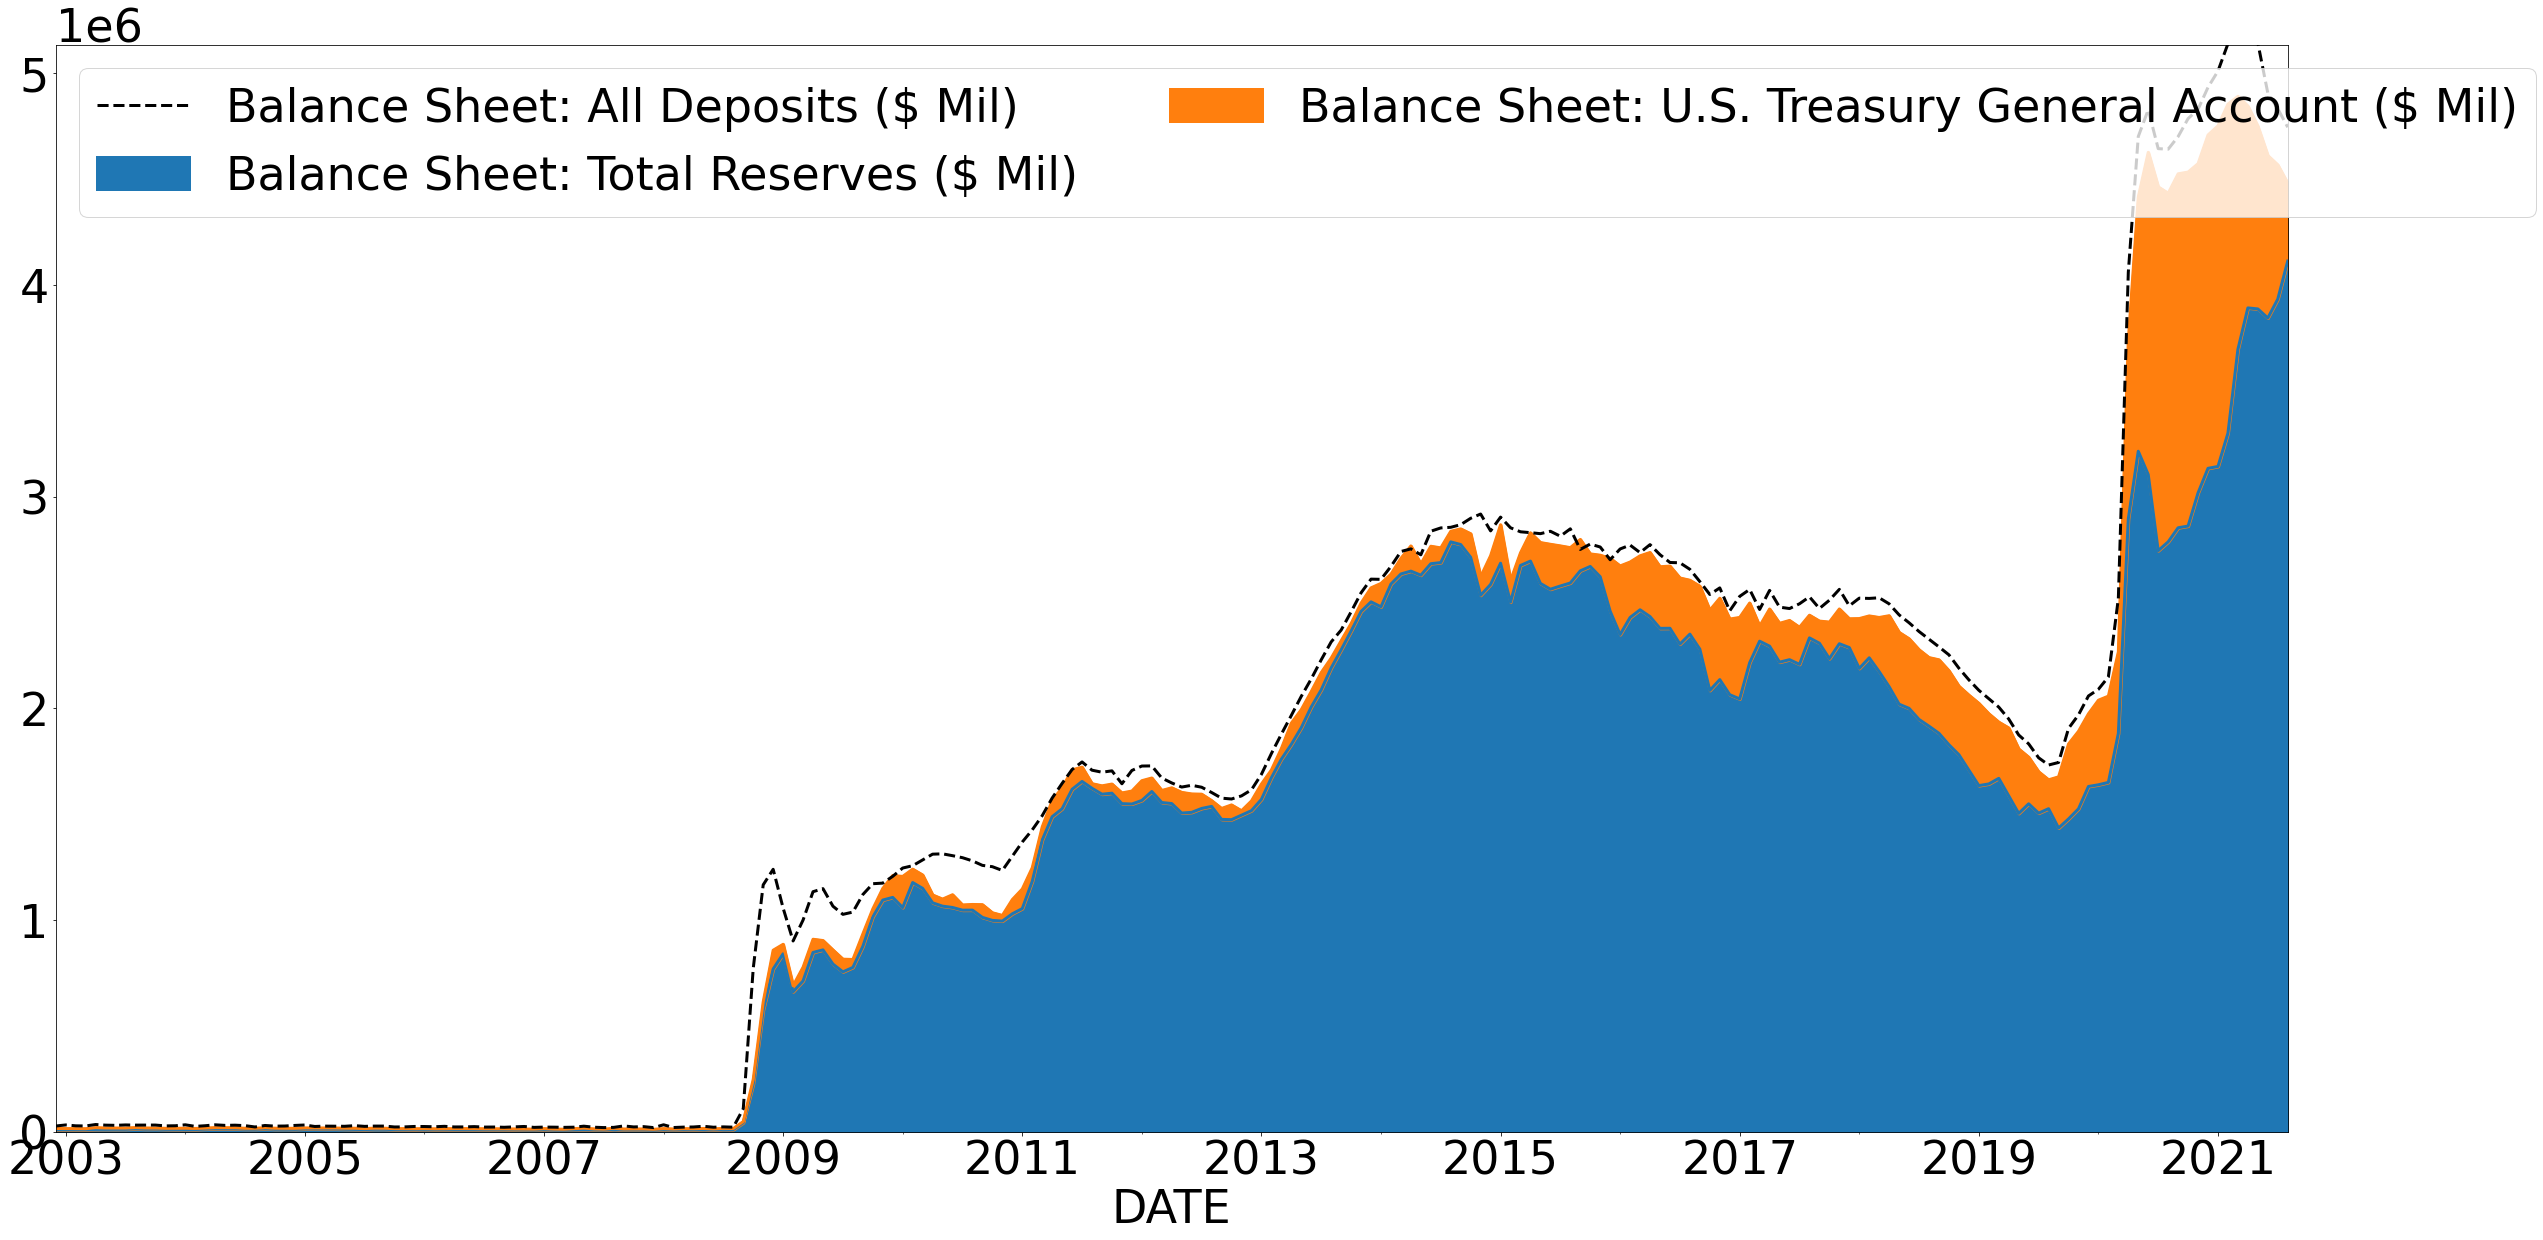

In [44]:
#fedProject
# . . . 
account_vars = ["Balance Sheet: Total Reserves ($ Mil)",
                "Balance Sheet: U.S. Treasury General Account ($ Mil)"]

plot_stacked_lines(data.loc["2002-12-31":],
                   account_vars,
                   linewidth = 3,
                   total_var = "Balance Sheet: All Deposits ($ Mil)", 
                   pp = pp)

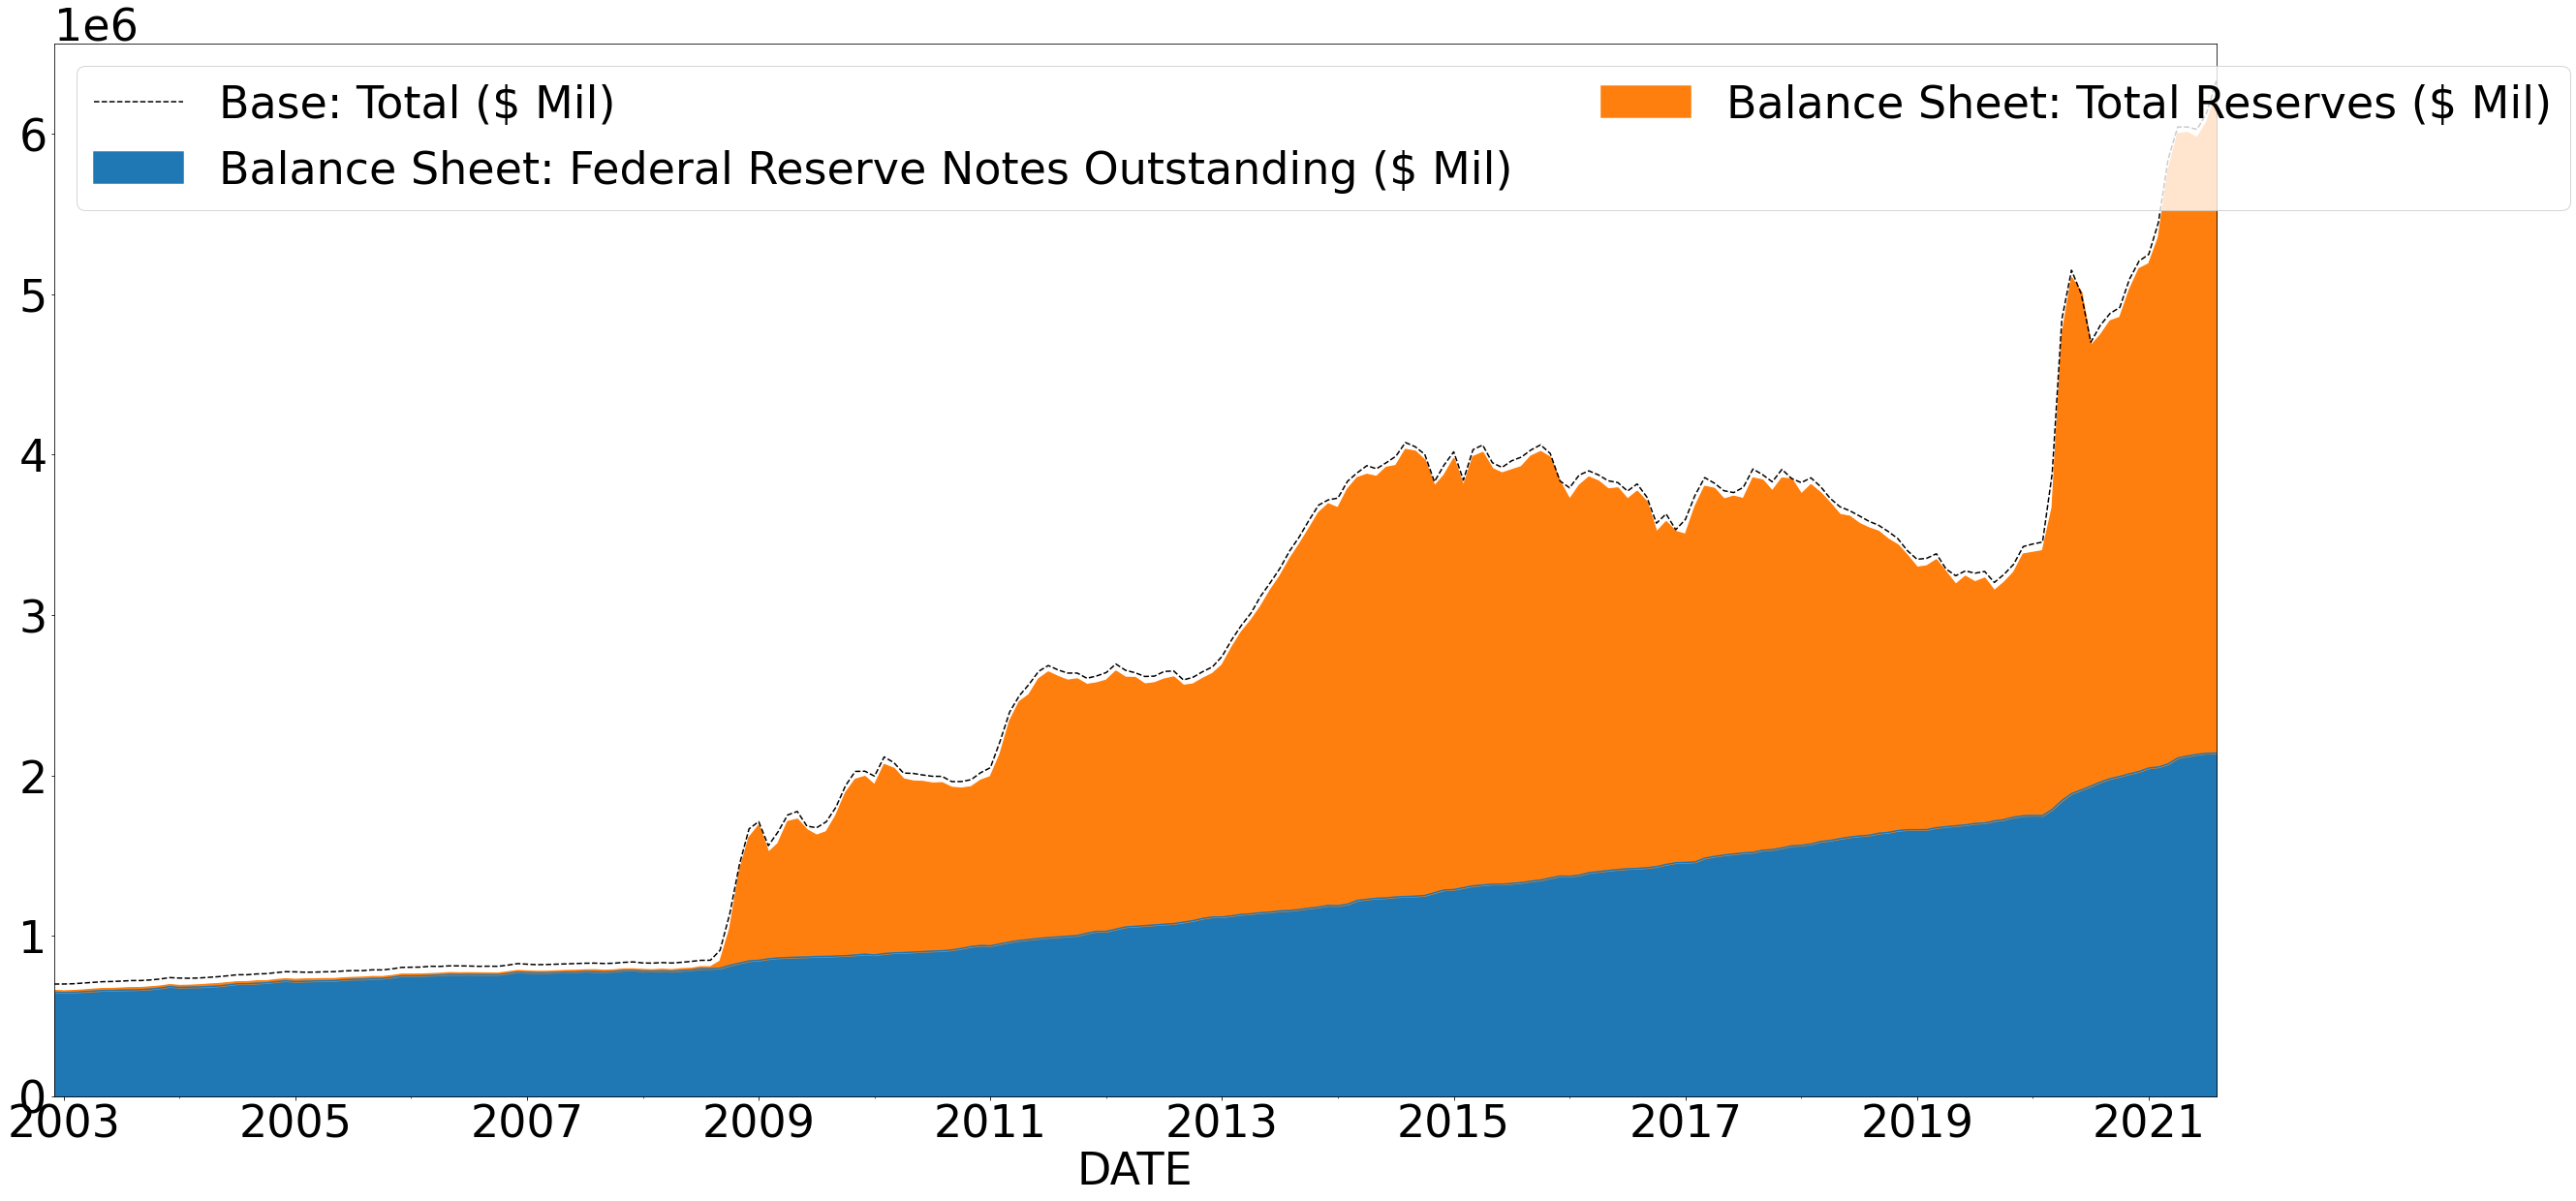

In [47]:
#fedProject
# . . . 
account_vars = ["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)",
                "Balance Sheet: Total Reserves ($ Mil)"]

plot_stacked_lines(data.loc["2002-12-31":],
                   account_vars,
                   linewidth = 1.5,
                   total_var = "Base: Total ($ Mil)",  
                   pp = pp)

In [48]:
data["Balance Sheet: Repos - Reverse Repos ($ Mil)"] =\
    data["Balance Sheet: Repos ($ Mil)"].sub(data["Balance Sheet: Reverse Repos ($ Mil)"])
data

Base: Total ($ Mil)  Base: Currency in Circulation ($ Mil)  \
DATE                                                                     
2002-01-31             653800.0                              635429.00   
2002-02-28             654600.0                              635884.00   
2002-03-31             659000.0                              639697.50   
2002-04-30             663400.0                              643579.50   
2002-05-31             668600.0                              648293.20   
...                         ...                                    ...   
2021-04-30            6042100.0                             2154819.25   
2021-05-31            6041900.0                             2167934.00   
2021-06-30            6027100.0                             2178871.20   
2021-07-31            6130300.0                             2186184.25   
2021-08-31            6328800.0                             2187688.75   

            Balance Sheet: Total Assets ($ Mil)  \
DATE                                              
2002-01-31                                  NaN   
2002-02-28                                  NaN   
2002-03-31                                  NaN   
2002-04-30                                  NaN   
2002-05-31                                  NaN   
...                                         ...   
2021-04-30                           7775974.00   
2021-05-31                           7866893.25   
2021-06-30                           8026555.20   
2021-07-31                           8190356.75   
2021-08-31                           8291893.25   

            Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)  \
DATE                                                                        
2002-01-31                                                NaN               
2002-02-28                                                NaN               
2002-03-31                                                NaN               
2002-04-30                                                NaN               
2002-05-31                                                NaN               
...                                                       ...               
2021-04-30                                         7614925.00               
2021-05-31                                         7709974.25               
2021-06-30                                         7874851.20               
2021-07-31                                         8042917.00               
2021-08-31                                         8153497.75               

            Balance Sheet: Securities Held Outright ($ Mil)  \
DATE                                                          
2002-01-31                                              NaN   
2002-02-28                                              NaN   
2002-03-31                                              NaN   
2002-04-30                                              NaN   
2002-05-31                                              NaN   
...                                                     ...   
2021-04-30                                       7207246.25   
2021-05-31                                       7291913.75   
2021-06-30                                       7450341.40   
2021-07-31                                       7617340.75   
2021-08-31                                       7733453.75   

            Balance Sheet: U.S. Treasuries Held Outright ($ Mil)  \
DATE                                                               
2002-01-31                                                NaN      
2002-02-28                                                NaN      
2002-03-31                                                NaN      
2002-04-30                                                NaN      
2002-05-31                                                NaN      
...                                                       ...      
2021-04-30         

<ipython-input-24-d2f49b60d242>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x, 2) for x in vals])


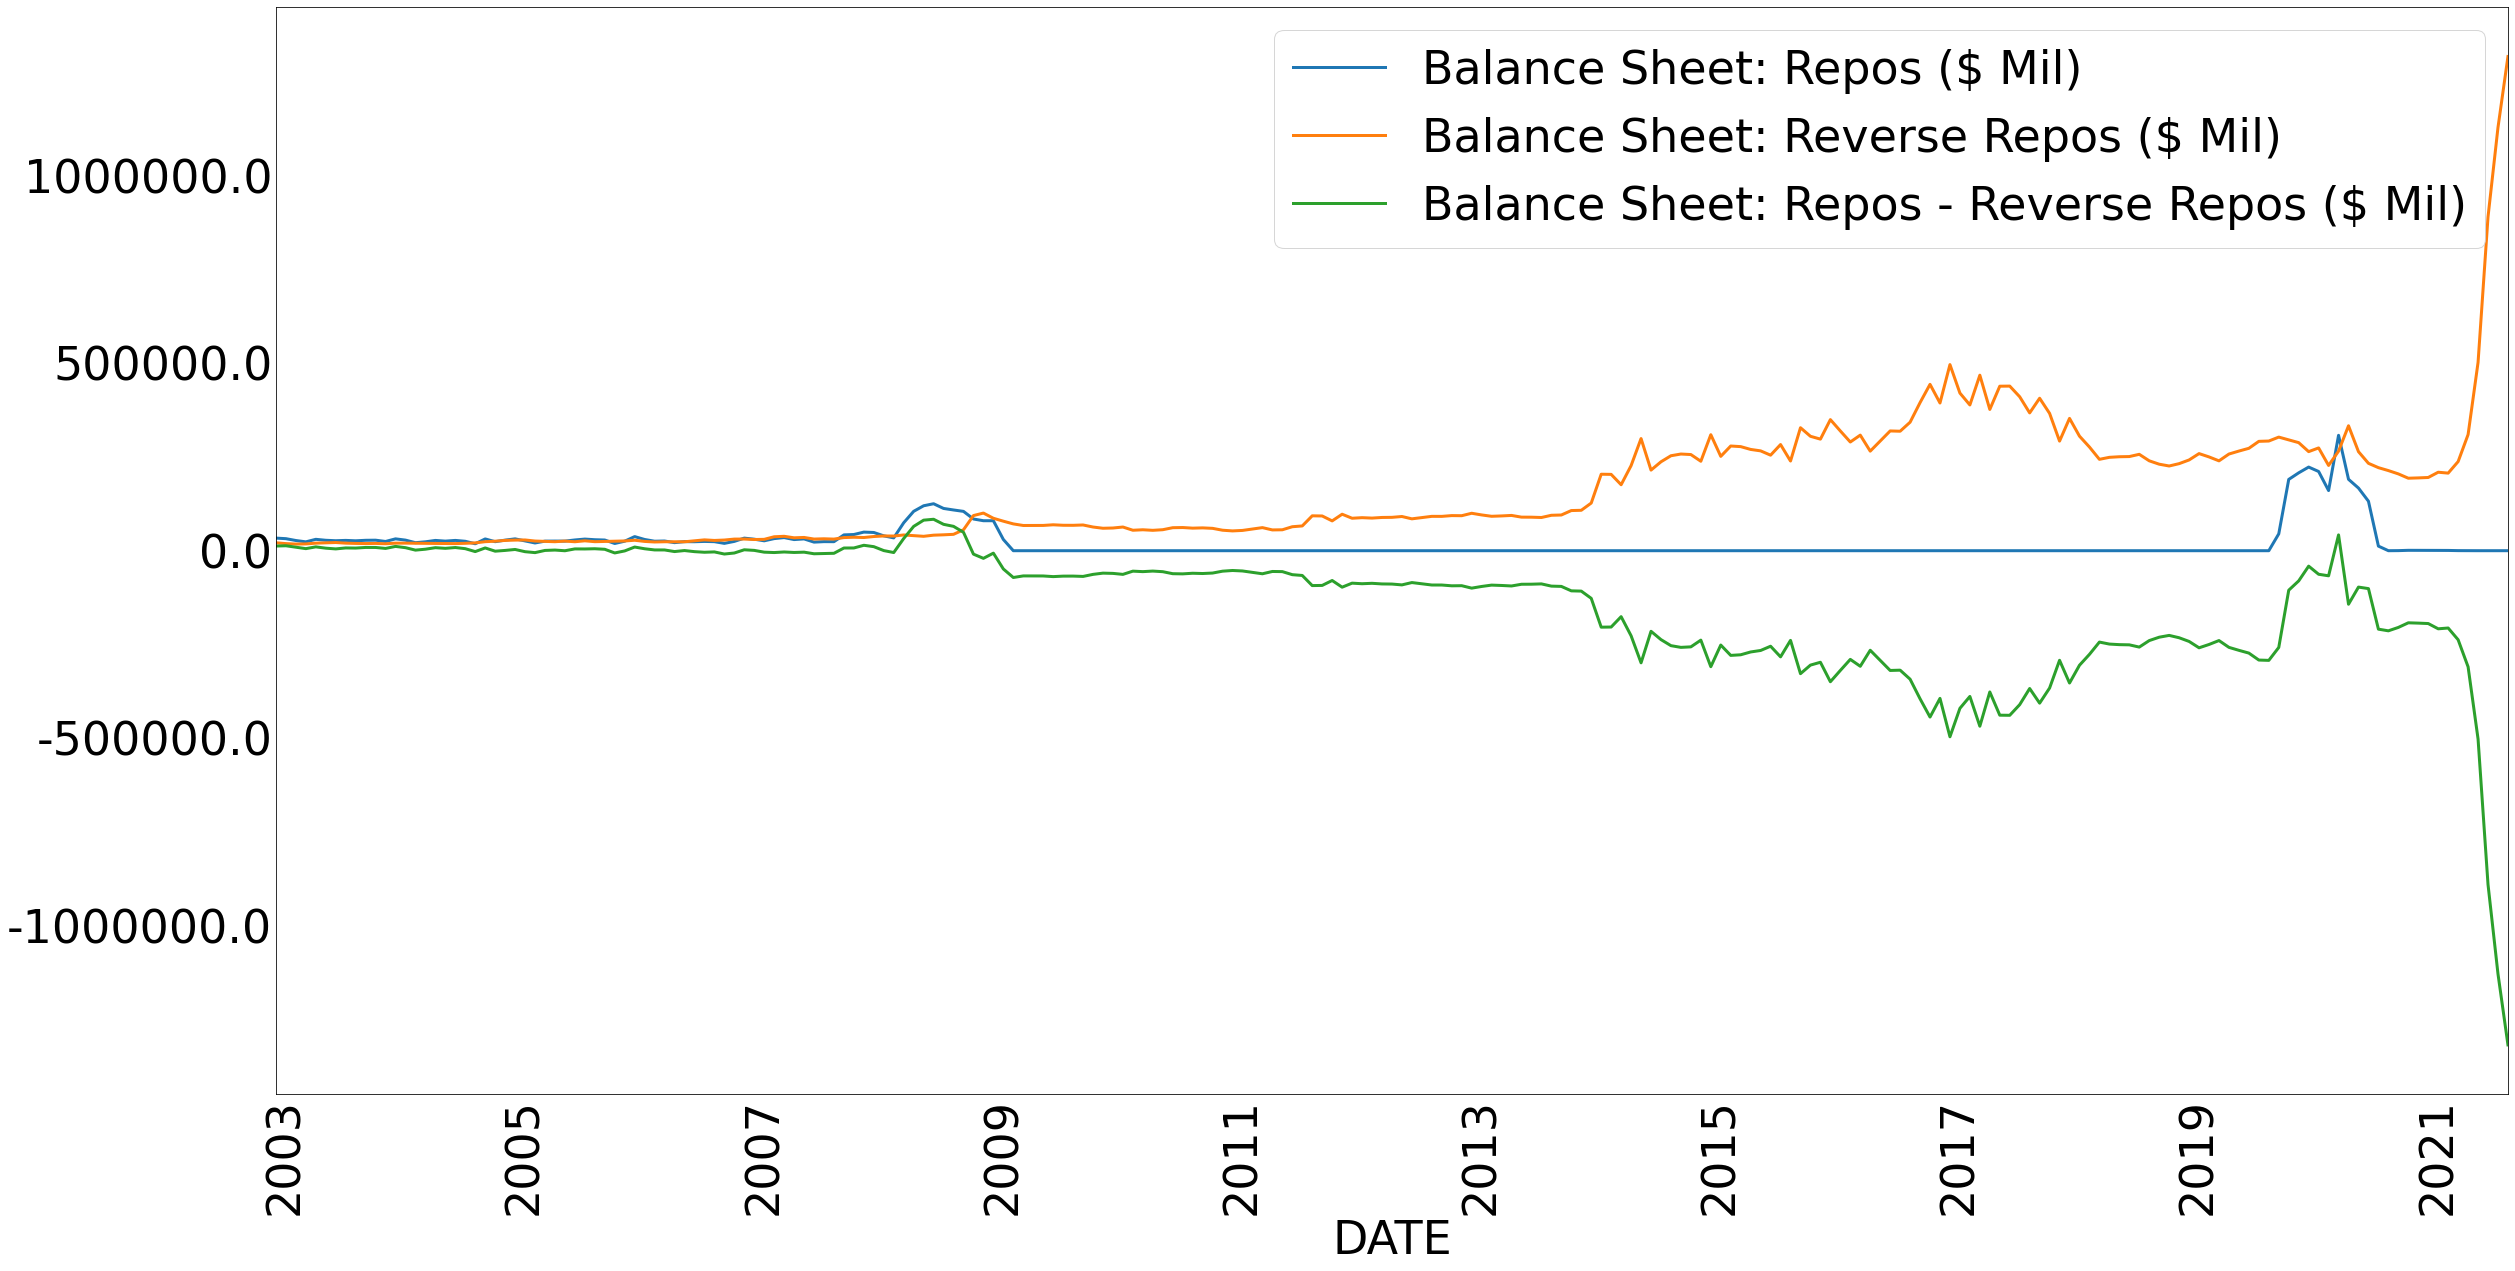

In [49]:

overnight_vars = ["Balance Sheet: Repos ($ Mil)",
                  "Balance Sheet: Reverse Repos ($ Mil)",
                  "Balance Sheet: Repos - Reverse Repos ($ Mil)"]
plot_lines(data[overnight_vars],
          linewidth = 3)

In [ ]:
pp.close()